# Deep Learning for Microbiome Analysis

#### Nikolay Oskolkov, SciLifeLab, NBIS Long Term Support, [nikolay.oskolkov@scilifelab.se](nikolay.oskolkov@scilifelab.se)

<h3><center>Abstract</center></h3>
In this notebook, we will demonstrate how to use Convolutional Neural Networks (CNN) for building a microbial sequence classifier for predicting microbial tissue composition for a given shotgun metagenomics sample starting from raw sequences in a fastq-file.

### Table of Contents:
* [QIIME and SourceTracker](#QIIME-and-SourceTracker)
* [Human Microbiome Project Data](#Human-Microbiome-Project-Data)
* [Selecting Informative Microbial Organisms](#Selecting-Informative-Microbial-Organisms)
* [Preparing Data for CNN Classifier](#Preparing-Data-for-CNN-Classifier)
* [Training Convolutional Neural Network](#Training-Convolutional-Neural-Network)
* [Making Predictions of Microbial Composition](#Making-Predictions-of-Microbial-Composition)

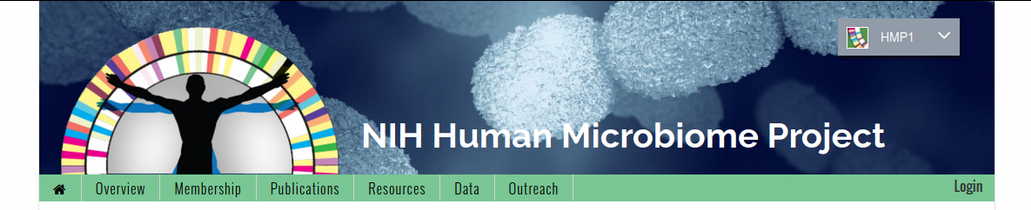

In [1]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/DeepLearningMetagenomics/images/hmp.png', width = 2000)

### QIIME and SourceTracker <a class="anchor" id="QIIME-and-SourceTracker"></a>

The idea of estimating microbial composition for a given sample is inspired by the popular [QIIME](http://qiime.org/) tool called [SourceTracker](http://qiime.org/tutorials/source_tracking.html). Originally, SourceTracker was built on 16S data, i.e. using only 16S ribosomal RNA genes. In contrast, here we will try to train a classifier using **shotgun metagenomics data**. In addition, SourceTracker was not designed to be used on raw metagenomics sequences, but instead it needs microbial abundabces ([OTU abundances](https://en.wikipedia.org/wiki/Operational_taxonomic_unit)) quantified in some way, e.g. through the [QIIME](http://qiime.org/) pipeline, [MetaPhlan](https://huttenhower.sph.harvard.edu/metaphlan2/) or [Kraken](https://ccb.jhu.edu/software/kraken2/). In contrast, the goal of the CNN classifier we will train here is to go from a **fastq-file** to predicting microbial composition of a metagenomic sample.

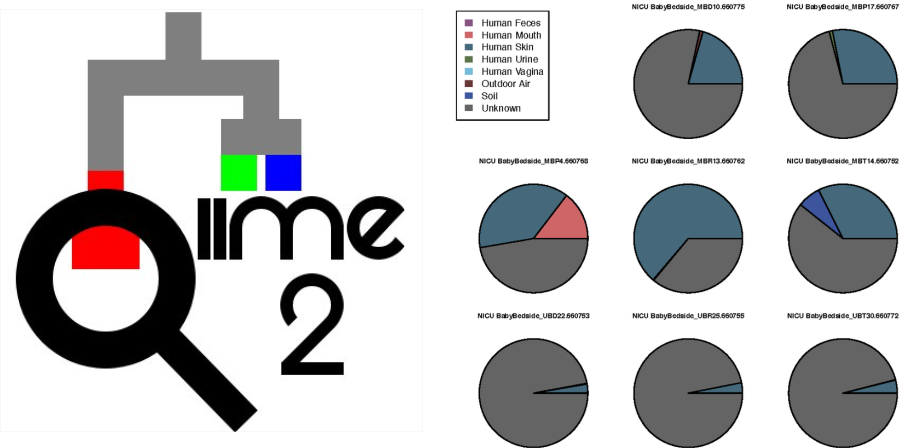

In [4]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/DeepLearningMetagenomics/images/qiime_plus_sourcetracker.png', width = 2000)

The details of the SourceTracker algorithm can be found in the [original SourceTracker publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3791591/). It is a Bayesian version of Gaussian Mixture Model (GMM) clustering algorithm (seems similar to the [Direchlet Multinomial Mixtures](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0030126)) that is trained / fit on a reference data set called **Sources** (i.e. different classes such as Soil or Human Oral or Human Gut), and can estimate proportion / contribution of each Source into test samples called **Sinks**, therefore the SourceTracker algorithm explicitly models a Sink sample as a **mixture** of Sources. The Bayesian flavour of the algorithm comes from using **Direchlet priors** when fitting the model.

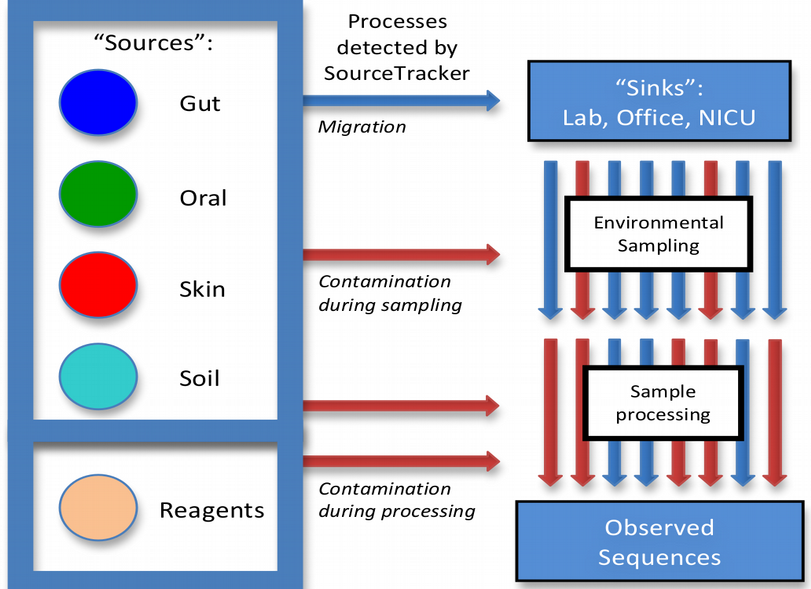

In [3]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/DeepLearningMetagenomics/images/SourceTracker.png', width = 2000)

In the [original SourceTracker publication](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3791591/), the authors demonstrate that the Bayesian incorporation of uncertainties into the prediction procedure allows to outperform other analogous Machine Learning algorithms such as Naive Bayes and random Forest.

### Human Microbiome Project Data <a class="anchor" id="Human-Microbiome-Project-Data"></a>

As a data source we will use the results of the Human Microbiome Project (HMP).

Human Microbiome Project (HMP) provides a fantastic resource for the reference of human microbiome. The project accumulated [large amount of data](https://portal.hmpdacc.org/) from different human "tissues", or rather microbial communities such as Gut, Skin, Oral etc. communities. We will use the table of microbial abundances produced by Metaphlan2 for different tissues from here https://www.hmpdacc.org/hmsmcp2/, let us read and have a look at the data:

In [3]:
import numpy as np
import pandas as pd

#If you would like to start working directly with bacteria on genus level please uncomment the lines below
#microb = microb[[i for i in list(microb.columns) if not 's__' in i and 'g__' in i and 'k__Bacteria' in i]]
#print(microb.shape)

microb = pd.read_csv('/home/nikolay/Documents/Medium/DeepLearningMetagenomics/microb.txt', sep = '\t')
microb

k__Archaea  k__Archaea|p__Euryarchaeota  \
SRS011061    0.000000                     0.000000   
SRS011084    0.000000                     0.000000   
SRS011086    0.000000                     0.000000   
SRS011090    0.000000                     0.000000   
SRS011098    0.000000                     0.000000   
...               ...                          ...   
SRS971275    0.001156                     0.001156   
SRS971276    0.000380                     0.000380   
SRS971277    0.000000                     0.000000   
SRS971427    0.000000                     0.000000   
SRS971428    0.000000                     0.000000   

           k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
SRS011061                                        0.000000   
SRS011084                                        0.000000   
SRS011086                                        0.000000   
SRS011090                                        0.000000   
SRS011098                                        0.000000   
...                                                   ...   
SRS971275                                        0.001156   
SRS971276                                        0.000380   
SRS971277                                        0.000000   
SRS971427                                        0.000000   
SRS971428                                        0.000000   

           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
SRS011061                                           0.000000                      
SRS011084                                           0.000000                      
SRS011086                                           0.000000                      
SRS011090                                           0.000000                      
SRS011098                                           0.000000                      
...                                                      ...                      
SRS971275                                           0.001156                      
SRS971276                                           0.000380                      
SRS971277                                           0.000000                      
SRS971427                                           0.000000                      
SRS971428                                           0.000000                      

           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
SRS011061                                           0.000000                                             
SRS011084                                           0.000000                                             
SRS011086                                           0.000000                                             
SRS011090                                           0.000000                                             
SRS011098                                           0.000000                                             
...                                                      ...                                             
SRS971275                                           0.001156                                             
SRS971276                                           0.000380                                             
SRS971277                                           0.000000                                             
SRS971427                                           0.000000                                             
SRS971428                                           0.000000                                             

           k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
SRS011061                                           0.000000                                                                   
SRS011084                                           0.000000                                           

The microbial abundances were measured for **2437 microbes** at different taxonomic levels, and **2335 samples** coming from different human tissues: Oral, Gut, Skin and Vaginal microbiomes. Let us display phenotypic variables available for the HMP data. There are not some any useful phenotypes, but perhaps of particular interest are **STArea** that means the tissues of origin, **Gender** and **STSite** that stands for the more specific method  or site of the body where the microbes originate from. Here we will also build a "Color" variable where Gut samples are going to be "blue", Oral samples "red", Skin samples "green" and Vaginal samples "orange".

In [4]:
import warnings
warnings.filterwarnings("ignore")

phen = pd.read_csv('/home/nikolay/Documents/Medium/DeepLearningMetagenomics/phen.txt', sep = '\t')
phen['Color'] = 'blue'
phen['Color'][phen['STArea'] == 'Oral'] = 'red'
phen['Color'][phen['STArea'] == 'Skin'] = 'green'
phen['Color'][phen['STArea'] == 'Vaginal'] = 'orange'
phen

ID         SN    RANDSID VISNO STArea                STSite  \
0     SRS011061  700014562  158458797     1    Gut                 Stool   
1     SRS011084  700014724  158479027     1    Gut                 Stool   
2     SRS011086  700014733  158458797     1   Oral         Tongue_dorsum   
3     SRS011090  700014739  158458797     1   Oral         Buccal_mucosa   
4     SRS011098  700014751  158458797     1   Oral  Supragingival_plaque   
...         ...        ...        ...   ...    ...                   ...   
2350  SRS971275  700098267  158742018     2    Gut                 Stool   
2351  SRS971276  700097291  158013734   02S    Gut                 Stool   
2352  SRS971277  700032257  159753524     1   Oral         Tongue_dorsum   
2353  SRS971427  700016920  159389382     1   Skin        Anterior_nares   
2354  SRS971428  700016601  159227541     1   Skin        Anterior_nares   

         SNPRNT  Gender  WMSPhase  Color  
0     700014555  Female         1   blue  
1     700014718    Male         1   blue  
2     700014731  Female         1    red  
3     700014737  Female         1    red  
4     700014749  Female         1    red  
...         ...     ...       ...    ...  
2350  700098267  Female         4   blue  
2351  700097291  Female         4   blue  
2352  700032228  Female         4    red  
2353  700016920    Male         4  green  
2354  700016560  Female         4  green  

[2355 rows x 10 columns]

Let us display the numbers of samples available from the **Oral, Gut, Skin and Vaginal microbial communities**. It looks like the Oral microbiome samples are doiminating, and are at least twice as many as of Gut, Skin and Vaginal samples. However, overall the dataset does not look crazy imbalanced which is good for training a CNN classifier.

In [5]:
phen['STArea'].value_counts()

Oral       1259
Gut         553
Skin        309
Vaginal     234
Name: STArea, dtype: int64

In [6]:
phen['Gender'].value_counts()

Female    1266
Male      1089
Name: Gender, dtype: int64

In [7]:
phen['STSite'].value_counts()

Stool                      553
Tongue_dorsum              418
Supragingival_plaque       378
Buccal_mucosa              371
Anterior_nares             253
Posterior_fornix           209
R_Retroauricular_crease     32
Palatine_Tonsils            25
Subgingival_plaque          24
L_Retroauricular_crease     23
Throat                      18
Keratinized_gingiva         17
Mid_vagina                  14
Vaginal_introitus           11
Saliva                       7
Hard_palate                  1
R_Antecubital_fossa          1
Name: STSite, dtype: int64

Above we can see that the fecal samples (Stool) represent the majority of HMP samples, this should correspond to the Gut tissue. Another thing is that the HMP samples seem to be pretty balanced with respect to Gender, i.e. nearly as many Female samples as Male ones. Next, we are going to visualize the samples using dimensionality reduction techniques such as **Principal Component Analysis (PCA)** and **tSNE**, we are also going to color the samples by their tissues of origin.

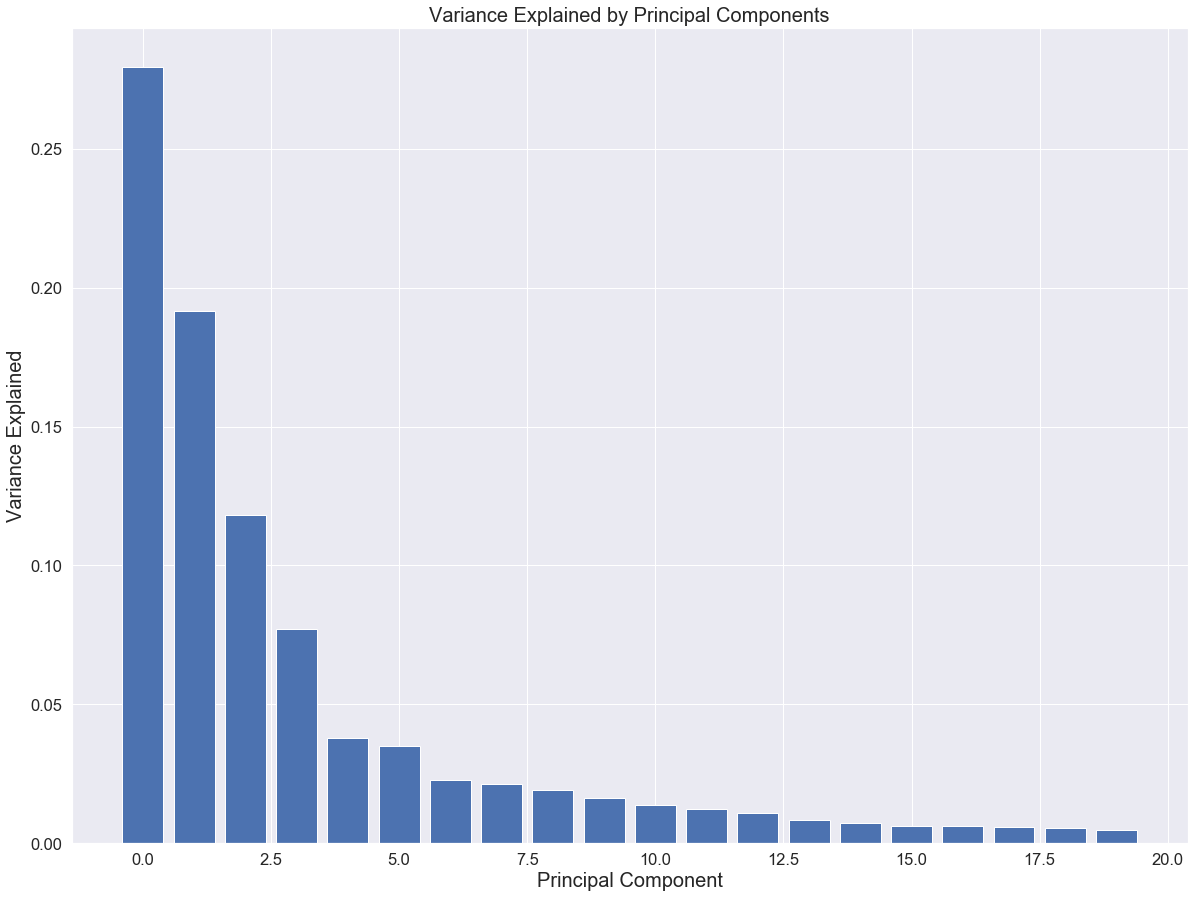

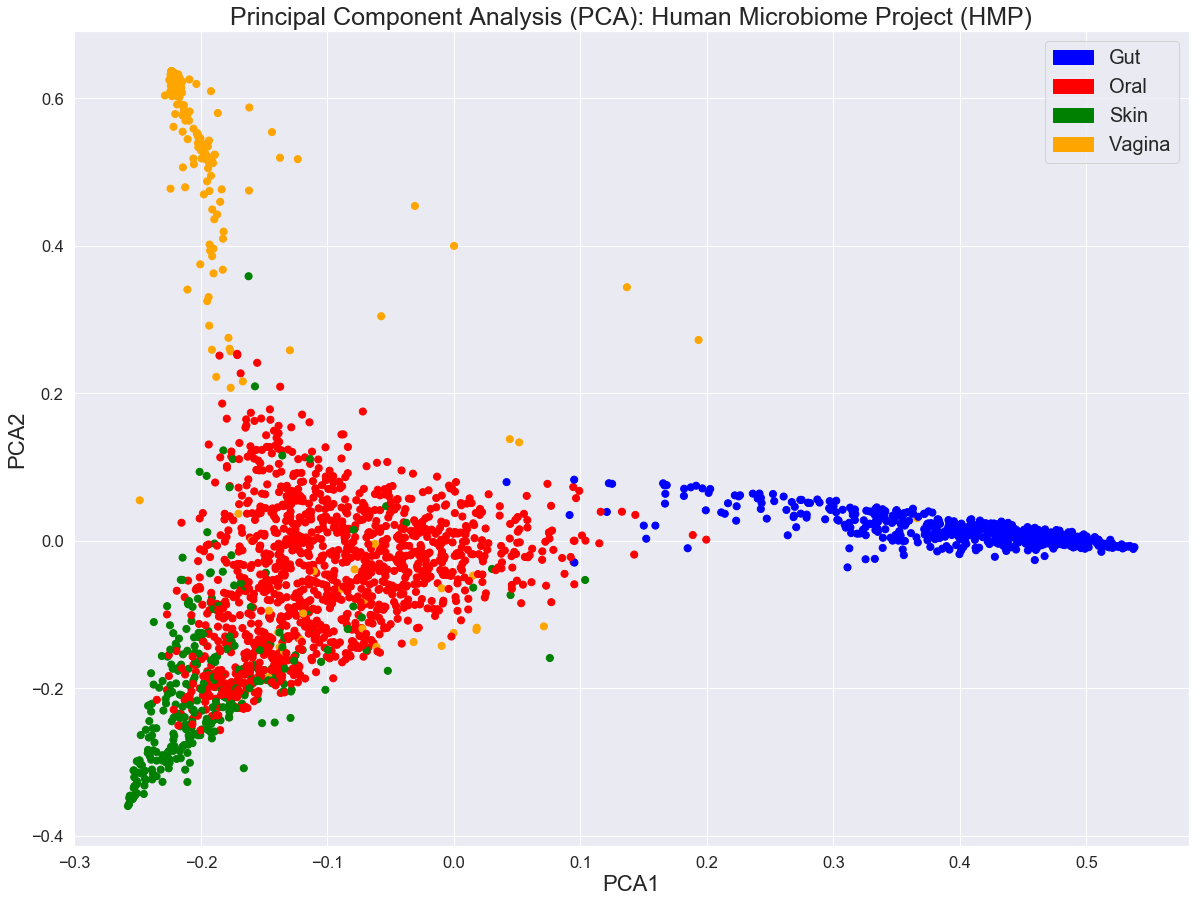

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2355 samples in 0.475s...
[t-SNE] Computed neighbors for 2355 samples in 11.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2355
[t-SNE] Computed conditional probabilities for sample 2000 / 2355
[t-SNE] Computed conditional probabilities for sample 2355 / 2355
[t-SNE] Mean sigma: 0.048677
[t-SNE] Computed conditional probabilities in 0.204s
[t-SNE] Iteration 50: error = 61.6576271, gradient norm = 0.0270526 (50 iterations in 0.630s)
[t-SNE] Iteration 100: error = 60.8073425, gradient norm = 0.0169747 (50 iterations in 0.536s)
[t-SNE] Iteration 150: error = 60.5044594, gradient norm = 0.0226146 (50 iterations in 0.531s)
[t-SNE] Iteration 200: error = 60.3357506, gradient norm = 0.0184539 (50 iterations in 0.528s)
[t-SNE] Iteration 250: error = 60.2371140, gradient norm = 0.0199262 (50 iterations in 0.531s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.237114
[t-SNE] Iteration 300: er

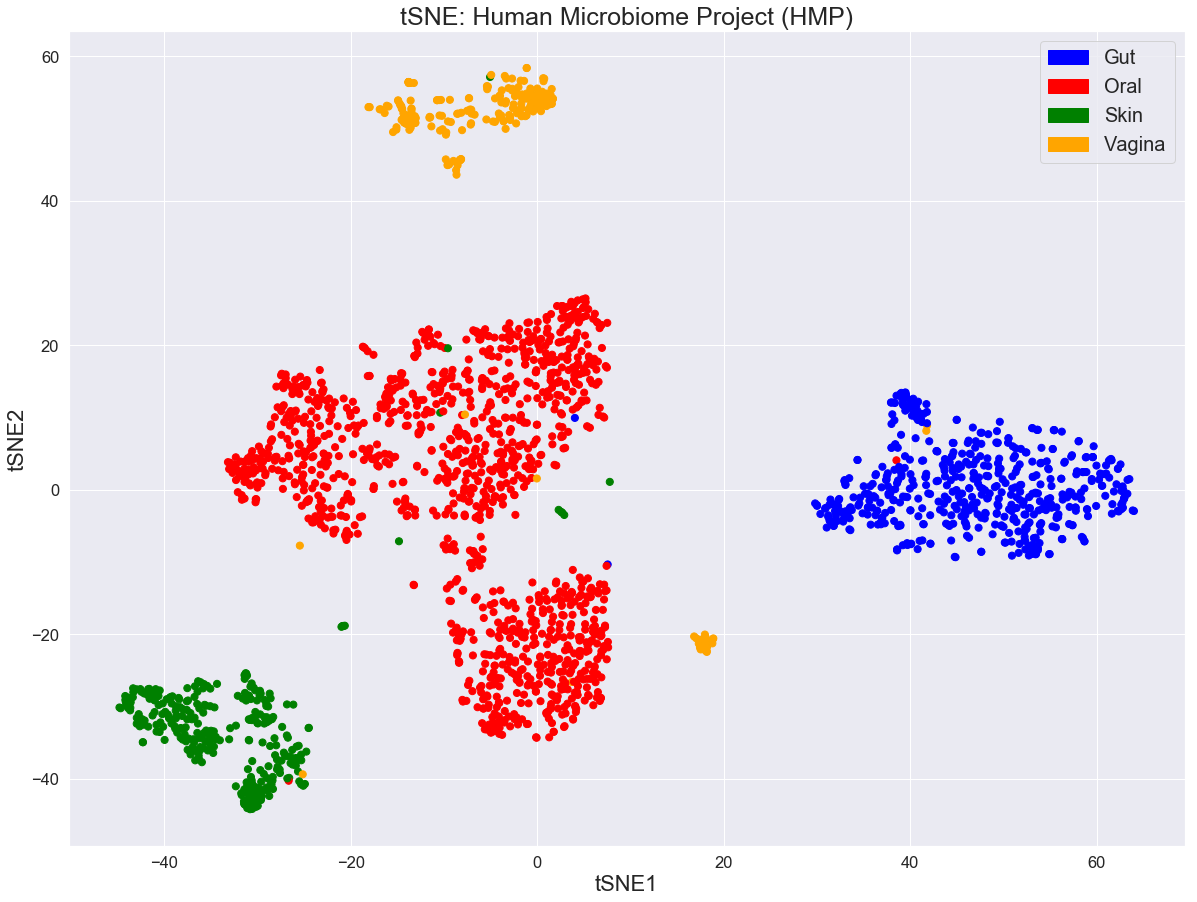

In [9]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set(font_scale = 1.5)

import numpy as np
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = microb.values
X = np.log10(X + 1)

plt.figure(figsize = (20, 15))
pca = PCA(n_components = 20).fit(X)
index = np.arange(len(pca.explained_variance_ratio_))
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Variance Explained by Principal Components', fontsize = 20)
plt.xlabel("Principal Component", fontsize = 20)
plt.ylabel("Variance Explained", fontsize = 20)
plt.show()

plt.figure(figsize = (20, 15))
X_reduced = PCA(n_components = 2).fit_transform(X)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], s = 50, c = phen['Color'])
plt.title('Principal Component Analysis (PCA): Human Microbiome Project (HMP)', fontsize = 25)
plt.xlabel("PCA1", fontsize = 22); plt.ylabel("PCA2", fontsize = 22)

from matplotlib import cm
import matplotlib.patches as mpatches
my_legends = [mpatches.Patch(color = 'blue', label = 'Gut'), 
              mpatches.Patch(color = 'red', label = 'Oral'),
              mpatches.Patch(color = 'green', label = 'Skin'),
              mpatches.Patch(color = 'orange', label = 'Vagina')]
plt.legend(handles = my_legends, fontsize = 20)
plt.show()

plt.figure(figsize = (20, 15))
model = TSNE(learning_rate = 200, n_components = 2, random_state = 123, perplexity = 50, 
             init = X_reduced, n_iter = 1000, verbose = 2)
tsne = model.fit_transform(X)
plt.scatter(tsne[:, 0], tsne[:, 1], s = 50, c = phen['Color'])
plt.title('tSNE: Human Microbiome Project (HMP)', fontsize = 25)
plt.xlabel("tSNE1", fontsize = 22); plt.ylabel("tSNE2", fontsize = 22)

from matplotlib import cm
import matplotlib.patches as mpatches
my_legends = [mpatches.Patch(color = 'blue', label = 'Gut'), 
              mpatches.Patch(color = 'red', label = 'Oral'),
              mpatches.Patch(color = 'green', label = 'Skin'),
              mpatches.Patch(color = 'orange', label = 'Vagina')]
plt.legend(handles = my_legends, fontsize = 20)
plt.show()

In both PCA and tSNE plots, we can see that the samples are clearly separable by the tissue of origin in terms of microbial abundances. This implies that it should be quite straighforward to train a CNN classifier that can predict the tissue of origin for a given sample by checking microbial DNA sequences in the sample. However, for making the PCA and tSNE plots we used microbial abundances and not sequencing data itself, therefore we will have to first extract microbial organisms that separate Gut, Oral, Skin and Vaginal samples the most. Reference genomes from these most discriminative microbial organisms will be used later for creating a sequence train data set for the CNN classifier.

### Selecting Informative Microbial Organisms <a class="anchor" id="Selecting-Informative-Microbial-Organisms"></a>
For selecting microbial organisms that separate the Gut, Oral, Skin and Vaginal samples the most, we could have trained for example a Random Forest classifier and looked at the feature importances and their effect directions. However, here it looks like there are plenty of **tissue-specific microbes**, i.e. microbes that have high abundance in one tissue but almost zero in all other tissues. For example, if we look at **Haemophilus parahaemolyticus** that has an index 1950 in the microbial abundance data frame, it looks very Oral-specific:

In [8]:
[print(i) for i in microb.columns if 'Haemophilus_parahaemolyticus' in i]

k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parahaemolyticus
k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parahaemolyticus|t__GCF_000262265


[None, None]

In [9]:
microb.columns.get_loc('k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pasteurellales' + \
                       '|f__Pasteurellaceae|g__Haemophilus|s__Haemophilus_parahaemolyticus')

1950

In [10]:
ind = 1950
groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                             ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                             ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                             ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
#data_boxplot['Abundance'] = np.log10(data_boxplot['Abundance'] + 1) 
groupped_data

Tissue  Abundance
0      Oral   0.000000
1      Oral   0.014740
2      Oral   0.000000
3      Oral   0.000076
4      Oral   0.000021
...     ...        ...
2350    Gut   0.000000
2351    Gut   0.000000
2352    Gut   0.000000
2353    Gut   0.000000
2354    Gut   0.000000

[2355 rows x 2 columns]

In [11]:
groupped_data.groupby('Tissue').mean()

Abundance
Tissue               
Gut      0.000000e+00
Oral     8.721778e-04
Skin     1.235275e-06
Vaginal  7.692308e-09

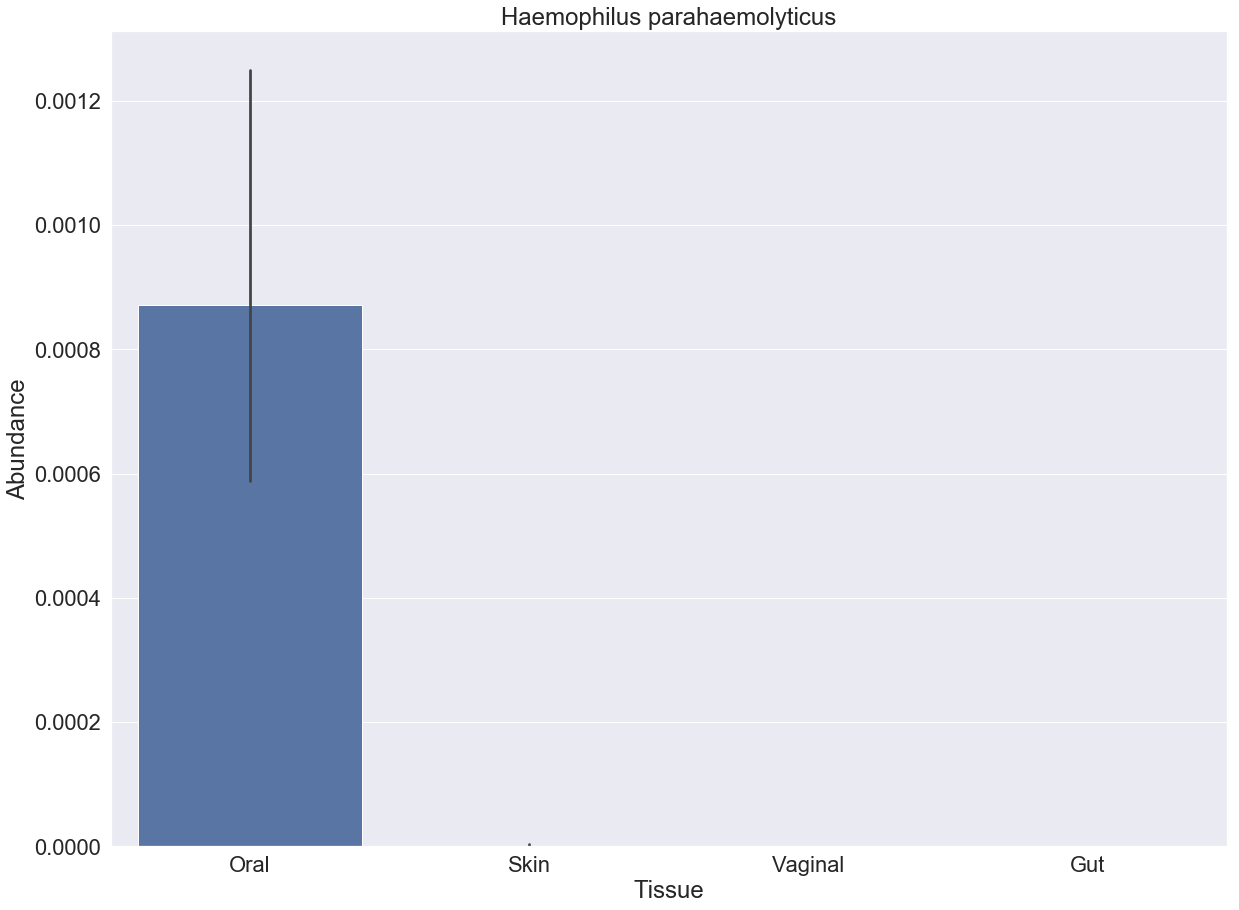

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 2)

plt.figure(figsize = (20, 15))
sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
plt.title('Haemophilus parahaemolyticus')
plt.show()

Let us visualize abundances of a few microbial organisms, we can see that some of them look very tissue-specific, i.e. they are present almost excusively only in one tissue while nearly absent in all other tissues. A few examples are **Bifidobacterium longum** which seems to be very gut-specific and reminds us about yogurts. **Neisseria gonorrhoeae** is a very oral-specific, **Staphylococcus aureus** is a known skin-specific bacteria, and **Gardnerella vaginalis** is a common marker of vaginal microbiota.

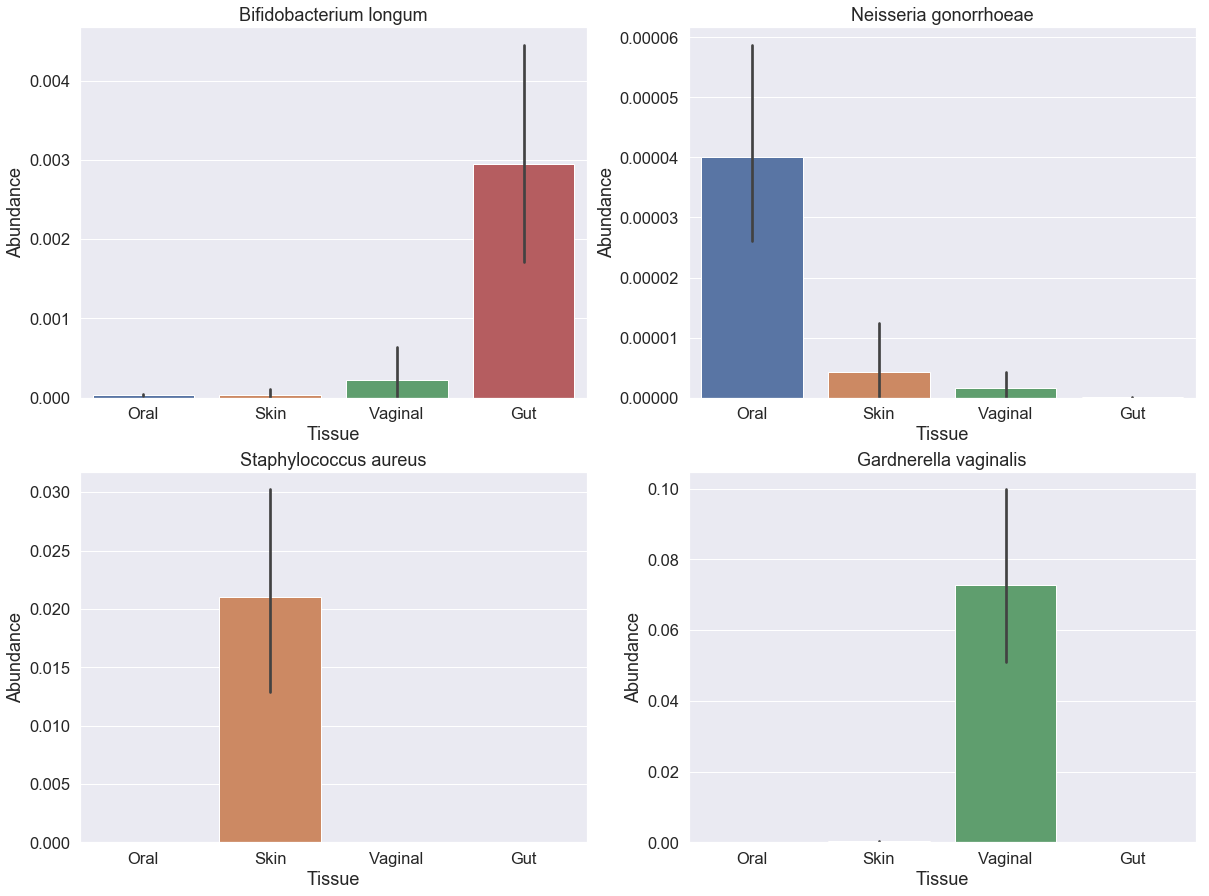

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,15))

sns.set(font_scale = 1.5)

sample_microb_names = ['Bifidobacterium longum', 'Neisseria gonorrhoeae', 
                       'Staphylococcus aureus', 'Gardnerella vaginalis']

for i, ind in enumerate([284, 1759, 786, 292]):
    
    plt.subplot(2, 2, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.title(sample_microb_names[i])

plt.show()

Let us display a few more interesting bacteria that often pop up in metagenomics projects, it is good to understand what tissue they belong to:

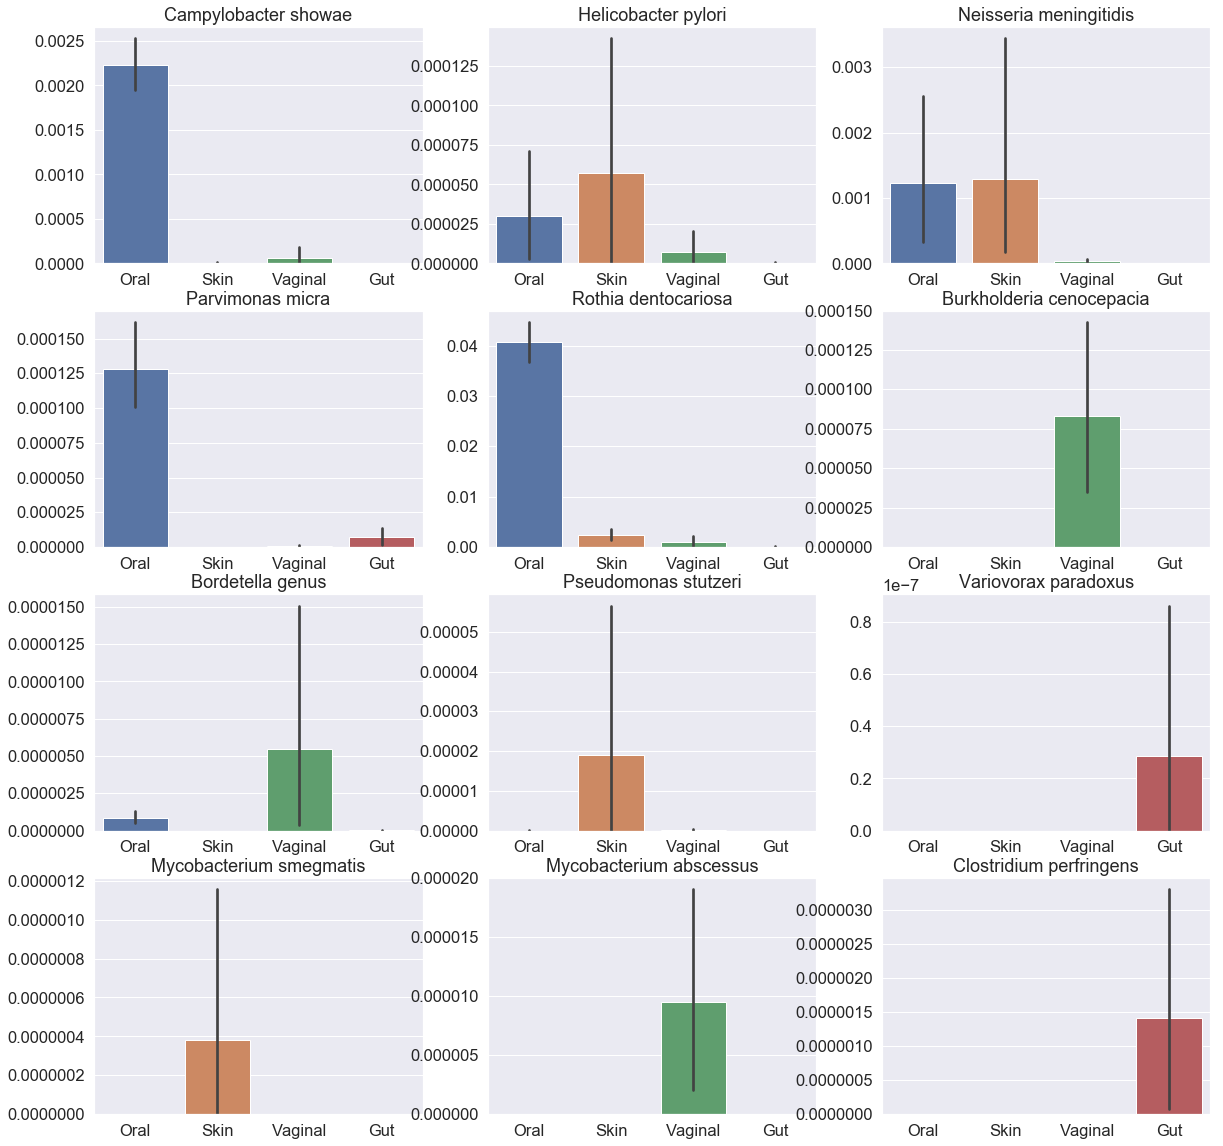

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))

sample_microb_names = ['Campylobacter showae', 'Helicobacter pylori', 'Neisseria meningitidis', 
                       'Parvimonas micra', 'Rothia dentocariosa', 'Burkholderia cenocepacia', 
                       'Bordetella genus', 'Pseudomonas stutzeri', 'Variovorax paradoxus', 
                       'Mycobacterium smegmatis', 'Mycobacterium abscessus', 'Clostridium perfringens']
for i, ind in enumerate([1821, 1832, 1765, 1100, 214, 1654, 1645, 2016, 1697, 230, 226, 1055]):
    
    plt.subplot(4, 3, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(sample_microb_names[i])

plt.show()

There are a few genera that have species that are tissue-specific in different tissues. For example, Streptococcus genus seems to be very much oral-specific. However, according to my experience, one can find Streptococcus species in other tissues such as gut. Indeed, here there are some examples of species from Streptococcus genus that are gut and oral specific:

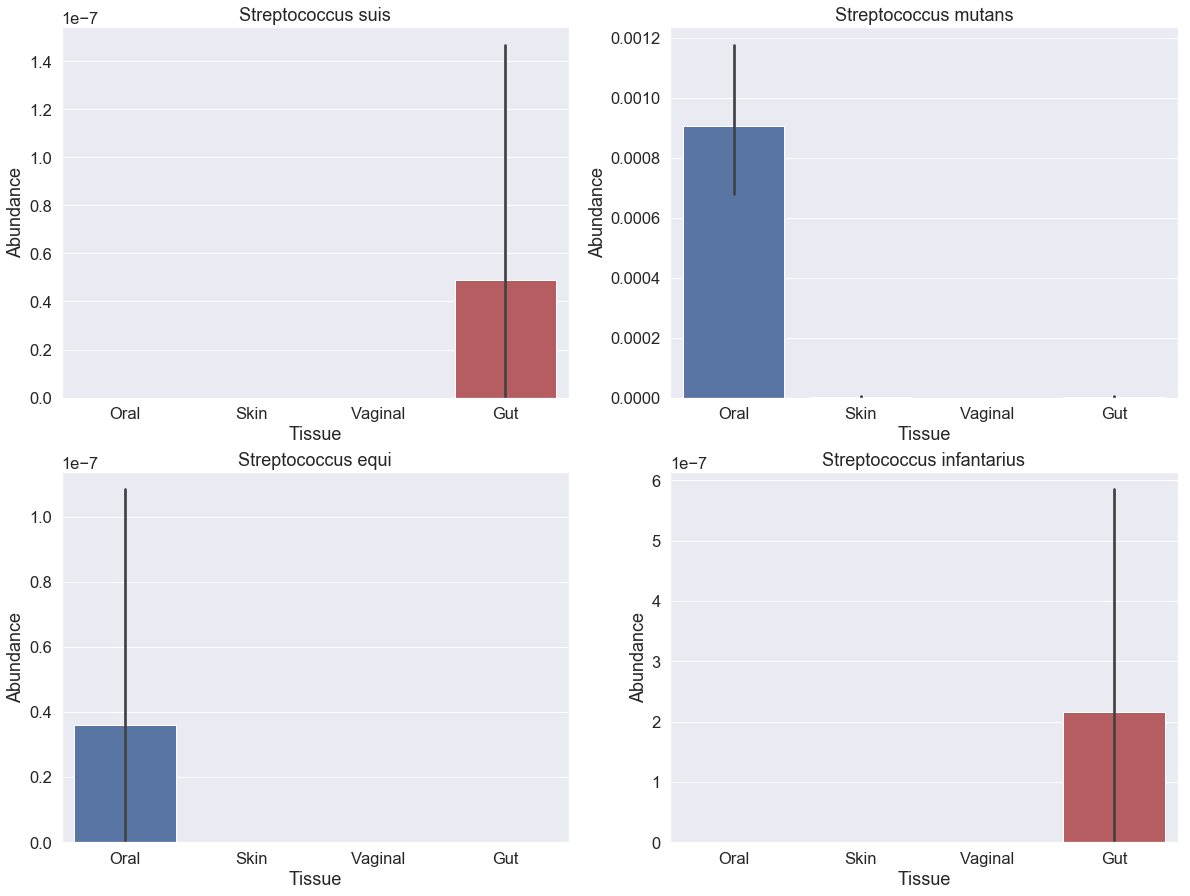

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20,15))

sns.set(font_scale = 1.5)

sample_microb_names = ['Streptococcus suis', 'Streptococcus mutans', 
                       'Streptococcus equi', 'Streptococcus infantarius']
for i, ind in enumerate([1009, 957, 937, 943]):
    
    plt.subplot(2, 2, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.title(sample_microb_names[i])

plt.show()

In the downstream analysis, for simplicity, we are going to concentrate on **bacterial microbes** only, i.e. archeae and viruses are going to be ignored, and only bacterial organisms classified only on **genus level** in the HMP data set will be kept for further downstream analysis.

We will build lists of tissue-specific bacterial genera and use their names for grepping bacterial reference genomes from the [RefSeq NCBI database](ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/bacteria/assembly_summary.txt). Hence, here we subset the total matrix of microbial abundances down to becterial genera abundances.

In [17]:
import numpy as np
import pandas as pd

#Here I attempted to filter out low abundant microbes using the following R codes:
#low.count.removal = function(data, # OTU count data frame of size n (sample) x p (OTU)
#                             percent=0.001 # cutoff chosen)
#                             {
#                                 keep.otu = which(colSums(data)*100/(sum(colSums(data))) > percent)
#                                 data.filter = data[,keep.otu]
#                                 return(list(data.filter = data.filter, keep.otu = keep.otu))
#                             }
#microb_clean<-low.count.removal(microb)$data.filter

#The microbe_clean.txt file contained microbes present in at least 0.1% of samples
#microb = pd.read_csv('/home/nikolay/Documents/Medium/DeepLearningMetagenomics/microb_clean.txt', sep = '\t')


#Select only bacterial genus level microbial abundances
microb = microb[[i for i in list(microb.columns) if not 's__' in i and 'g__' in i 
                 and 'k__Bacteria' in i and not 'noname' in i and not 'unclassified' in i]]

microb

k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Granulicella  \
SRS011061                                                0.0                                                         
SRS011084                                                0.0                                                         
SRS011086                                                0.0                                                         
SRS011090                                                0.0                                                         
SRS011098                                                0.0                                                         
...                                                      ...                                                         
SRS971275                                                0.0                                                         
SRS971276                                                0.0                                                         
SRS971277                                                0.0                                                         
SRS971427                                                0.0                                                         
SRS971428                                                0.0                                                         

           k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus  \
SRS011061                                                0.0                                                        
SRS011084                                                0.0                                                        
SRS011086                                                0.0                                                        
SRS011090                                                0.0                                                        
SRS011098                                                0.0                                                        
...                                                      ...                                                        
SRS971275                                                0.0                                                        
SRS971276                                                0.0                                                        
SRS971277                                                0.0                                                        
SRS971427                                                0.0                                                        
SRS971428                                                0.0                                                        

           k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum  \
SRS011061                                           0.000000                                                         
SRS011084                                           0.000000                                                         
SRS011086                                           0.000061                                                         
SRS011090                                           0.000000                                                         
SRS011098                                           0.014371                                                         
...                                                      ...                                                         
SRS971275                                           0.000000                                                         
SRS971276                                           0.000000                                                         
SRS971277                                           0.000000                                                         
SRS971427

We conclude that there are **227 bacterial genera** present in the HMP project.

Now, we are going to go through all the HMP bacterial genera and build lists of **Oral-specific**, **Skin-specific**, **Vagina-specific** and **Gut-specific** genera by using a criteriaon that if a bacterial genus is **10 times more abundant in one tissue compared to all other tissues**, this genus is considered to be tissue-specific. 

In [18]:
oral_specific_list = list(); oral_specific_ratio_list = list()
gut_specific_list = list(); gut_specific_ratio_list = list()
skin_specific_list = list(); skin_specific_ratio_list = list()
vagina_specific_list = list(); vagina_specific_ratio_list = list()

for ind in range(len(microb.columns)):
    
    my_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                           ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                           ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                           ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    
    ratio = float(my_data.groupby('Tissue', sort=False).mean().sort_values(
        'Abundance', ascending = True).iloc[3, :] / my_data.groupby('Tissue', sort = False).mean().sort_values(
        'Abundance', ascending = True).iloc[2, :])
    
    if( ratio > 10 and 'k__Bacteria' in microb.columns[ind] and 'g__' in microb.columns[ind]):
        
        if(my_data.groupby('Tissue', sort = False).mean().sort_values(
        'Abundance', ascending = True).index[3] == 'Oral'):
            oral_specific_list.append(microb.columns[ind])
            oral_specific_ratio_list.append(ratio)
        
        if(my_data.groupby('Tissue', sort = False).mean().sort_values(
        'Abundance', ascending = True).index[3] == 'Skin'):
            skin_specific_list.append(microb.columns[ind])
            skin_specific_ratio_list.append(ratio)
            
        if(my_data.groupby('Tissue', sort = False).mean().sort_values(
        'Abundance', ascending = True).index[3] == 'Vaginal'):
            vagina_specific_list.append(microb.columns[ind])
            vagina_specific_ratio_list.append(ratio)
            
        if(my_data.groupby('Tissue', sort = False).mean().sort_values(
        'Abundance', ascending = True).index[3] == 'Gut'):
            gut_specific_list.append(microb.columns[ind])
            gut_specific_ratio_list.append(ratio)
            
    if((ind + 1) % 100 == 0):
        print('Processed: {} microbes'.format(ind + 1))

Processed: 100 microbes
Processed: 200 microbes


Let us see how many vagina-specific bacterial genera we ended up with. In addition, below, we will display the **vagina-specific genera**:

In [19]:
len(vagina_specific_list)

16

In [20]:
vagina_specific_list

['k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella',
 'k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia',
 'k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae|g__Chlamydia',
 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Marinococcus',
 'k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus',
 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Asticcacaulis',
 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter',
 'k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospiril

We seem to have 16 vagina-specific bacterial genera that we can rank by the fold-change, i.e. mean abundance in the tissue of main presence divided by the mean abundance of the second main tissue of presence.

In [21]:
df_vagina_specific = pd.DataFrame({'BACTERIA': vagina_specific_list, 'RATIO': vagina_specific_ratio_list})
df_vagina_specific = df_vagina_specific.sort_values('RATIO', ascending = False)
df_vagina_specific = df_vagina_specific.iloc[0:df_vagina_specific.shape[0],:]
pd.options.display.max_colwidth = 170
df_vagina_specific

BACTERIA  \
3        k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Elizabethkingia   
4                             k__Bacteria|p__Chlamydiae|c__Chlamydiia|o__Chlamydiales|f__Chlamydiaceae|g__Chlamydia   
5                                 k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Marinococcus   
11        k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Achromobacter   
14     k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Herbaspirillum   
15                    k__Bacteria|p__Tenericutes|c__Mollicutes|o__Mycoplasmatales|f__Mycoplasmataceae|g__Ureaplasma   
2         k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella   
6                      k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus   
0              k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Mobiluncus   
12       k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Burkholderia   
9   k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Rhodospirillum   
10    k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Sphingomonadales|f__Sphingomonadaceae|g__Sphingopyxis   
8        k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Caulobacter   
13          k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Ralstonia   
7      k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Caulobacterales|f__Caulobacteraceae|g__Asticcacaulis   
1           k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Mycobacteriaceae|g__Mycobacterium   

           RATIO  
3            inf  
4            inf  
5            inf  
11           inf  
14  2.975405e+04  
15  6.047437e+02  
2   2.833811e+02  
6   2.495363e+02  
0   9.536711e+01  
12  5.581412e+01  
9   4.148335e+01  
10  3.696578e+01  
8   3.354955e+01  
13  2.512251e+01  
7   2.402896e+01  
1   2.074278e+01

In the list of vagina-specific bacterial genera (at least 10 times more abundant in the main tissue compared to any other tissue) above we can immediately see a few "strange" genera such as **Burkholderia** or **Ralstonia**. Those are very suspicious since there is some [evidence that they might be PCR reagent contaminants](https://bmcbiol.biomedcentral.com/articles/10.1186/s12915-014-0087-z). In the future, we will exclude them as well as two very lowly abundant and "noisy" genera: **Elizabethkingia** and **Herbaspirillum**. In total, this will give us **12 vagina-specific bacterial genera**. What about oral-, gut- and skin-specific genera?

In [22]:
len(oral_specific_list)

61

In [23]:
oral_specific_list

['k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermatophilaceae|g__Kineosphaera',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Pseudonocardiaceae|g__Saccharomonospora',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Alloscardovia',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Parascardovia',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Scardovia',
 'k__Bacteria|p__Actinobact

In [24]:
df_oral_specific = pd.DataFrame({'BACTERIA': oral_specific_list, 'RATIO': oral_specific_ratio_list})
df_oral_specific = df_oral_specific.sort_values('RATIO', ascending = False)
df_oral_specific = df_oral_specific.iloc[0:df_oral_specific.shape[0],:]
pd.options.display.max_colwidth = 170
df_oral_specific

BACTERIA  \
0                  k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Terriglobus   
22  k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XIII_Incertae_Sedis|g__Mogibacterium   
26                             k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Johnsonella   
28                          k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Shuttleworthia   
33                k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Eggerthia   
..                                                                                                                    ...   
14              k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Capnocytophaga   
21                           k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus   
38                        k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Veillonella   
31                k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptostreptococcaceae|g__Peptostreptococcus   
42                k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Burkholderiaceae|g__Lautropia   

        RATIO  
0         inf  
22        inf  
26        inf  
28        inf  
33        inf  
..        ...  
14  14.186069  
21  13.336718  
38  13.185902  
31  11.532787  
42  11.007495  

[61 rows x 2 columns]

In [25]:
len(skin_specific_list)

49

In [26]:
skin_specific_list

['k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Cellulomonadaceae|g__Cellulomonas',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Turicella',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dietziaceae|g__Dietzia',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Janibacter',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Agromyces',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Curtobacterium',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Kocuria',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actin

In [27]:
df_skin_specific = pd.DataFrame({'BACTERIA': skin_specific_list, 'RATIO': skin_specific_ratio_list})
df_skin_specific = df_skin_specific.sort_values('RATIO', ascending = False)
df_skin_specific = df_skin_specific.iloc[0:df_skin_specific.shape[0],:]
pd.options.display.max_colwidth = 170
df_skin_specific

BACTERIA  \
0               k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Cellulomonadaceae|g__Cellulomonas   
34                 k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Aeromonadales|f__Aeromonadaceae|g__Aeromonas   
26                 k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Agrobacterium   
27                     k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhizobiales|f__Rhizobiaceae|g__Rhizobium   
29           k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Acetobacteraceae|g__Roseomonas   
30                  k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Comamonadaceae|g__Delftia   
32               k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Massilia   
33                  k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Myxococcales|f__Myxococcaceae|g__Myxococcus   
35         k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Alteromonadales|f__Alteromonadaceae|g__Alishewanella   
17                                        k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Bacillus   
38        k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Morganella   
41          k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Rahnella   
42               k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Legionellales|f__Coxiellaceae|g__Rickettsiella   
43             k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas   
46                k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Pseudomonadales|f__Moraxellaceae|g__Moraxella   
47     k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Pseudoxanthomonas   
1                 k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Corynebacteriaceae|g__Turicella   
48                        k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella   
10             k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micromonosporaceae|g__Actinoplanes   
14                k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Bergeyella   
4                        k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Gordoniaceae|g__Gordonia   
5                k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Intrasporangiaceae|g__Janibacter   
6                  k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Agromyces   
7             k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Microbacteriaceae|g__Curtobacterium   
11                k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioides   
13                          k__Bacteria|p__Bacteroidetes|c__Cytophagia|o__Cytophagales|f__Cytophagaceae|g__Hymenobacter   
3                          k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dietziaceae|g__Dietzia   
16                               k__Bacteria|p__Deinococcus_Thermus|c__Deinococci|o__Thermales|f__Thermaceae|g__Thermus   
23                       k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Dolosigranulum   
15          k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Chryseobacterium   
19                            k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus   
2             k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Dermabacteraceae|g__Brachybacterium   
9                   k__Bacteria|p__Actinobacteria|c_

In [28]:
len(gut_specific_list)

53

In [29]:
gut_specific_list

['k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella',
 'k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter',
 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides',
 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella',
 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Butyricimonas',
 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter',
 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas',
 'k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacter

In [30]:
df_gut_specific = pd.DataFrame({'BACTERIA': gut_specific_list, 'RATIO': gut_specific_ratio_list})
df_gut_specific = df_gut_specific.sort_values('RATIO', ascending = False)
df_gut_specific = df_gut_specific.iloc[0:df_gut_specific.shape[0],:]
pd.options.display.max_colwidth = 170
df_gut_specific

BACTERIA  \
0            k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia   
48                     k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Brachyspiraceae|g__Brachyspira   
36          k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Turicibacter   
25                       k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Marvinbryantia   
41           k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Oxalobacteraceae|g__Oxalobacter   
32           k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Allobaculum   
14                                 k__Bacteria|p__Chlorobi|c__Chlorobia|o__Chlorobiales|f__Chlorobiaceae|g__Chlorobium   
46       k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Raoultella   
47         k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Shigella   
16                        k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Butyricicoccus   
8                   k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Dysgonomonas   
50                       k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Synergistes   
3            k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter   
49                    k__Bacteria|p__Synergistetes|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Pyramidobacter   
51       k__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae|g__Candidatus_Phytoplasma   
34         k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Coprobacillus   
20                         k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes   
45  k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Desulfovibrio   
6                  k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Butyricimonas   
40                       k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas   
38        k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Phascolarctobacterium   
44      k__Bacteria|p__Proteobacteria|c__Deltaproteobacteria|o__Desulfovibrionales|f__Desulfovibrionaceae|g__Bilophila   
37              k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus   
42          k__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Sutterellaceae|g__Parasutterella   
15                          k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc   
35            k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Holdemania   
28                        k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Anaerotruncus   
17                           k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium   
23                          k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus   
2              k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella   
1              k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella   
27                       k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter   
26                            k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridial

Let us write the lists of tissue-specific bacterial genera down to files.

In [31]:
with open('HMP_oral_specific_bacteria_genus.txt', 'w') as f:
    for item in oral_specific_list:
        f.write("%s\n" % item)
        
with open('HMP_gut_specific_bacteria_genus.txt', 'w') as f:
    for item in gut_specific_list:
        f.write("%s\n" % item)
        
with open('HMP_skin_specific_bacteria_genus.txt', 'w') as f:
    for item in skin_specific_list:
        f.write("%s\n" % item)
        
with open('HMP_vagina_specific_bacteria_genus.txt', 'w') as f:
    for item in vagina_specific_list:
        f.write("%s\n" % item)

Now, we are going to extract genera names by parsing the lists of the tissue-specific bacteria. We will put all the tissue specific genera names into a list of lists **tissue_specific_list** and save its 4 elements (4 lists) into separate files.

In [32]:
tissue_specific_list = []
for tissue in [oral_specific_list, gut_specific_list, skin_specific_list, vagina_specific_list]:

    parsed_genus_bacteria = list(set([i.split('|')[5] for i in tissue]))
    parsed_genus_bacteria = [i.replace('g__','') for i in parsed_genus_bacteria]
    
    tissue_specific_genera = list(set(parsed_genus_bacteria))
    print(len(tissue_specific_genera))
    
    tissue_specific_list.append(tissue_specific_genera)

61
53
49
16


We will also write the tissue-specific genera names down to text files.

In [33]:
for index, tissue in enumerate(['oral','gut','skin','vagina']):
    with open('tissue_specific_genera_names_' + tissue + '_full_list.txt', 'w') as f:
        for item in tissue_specific_list[index]:
            f.write("%s\n" % item)

We can see that human oral environment has 61 (the most) tissue-specefic microbial genera, while vagina has 16 (the least) tissue-specific genera.

To double check that we selected tissue-specific genera, let us plot their microbial abundances and visually instpect that the selected genera are indeed oral-specific, gut-specific, skin-specific and vagina-specific.

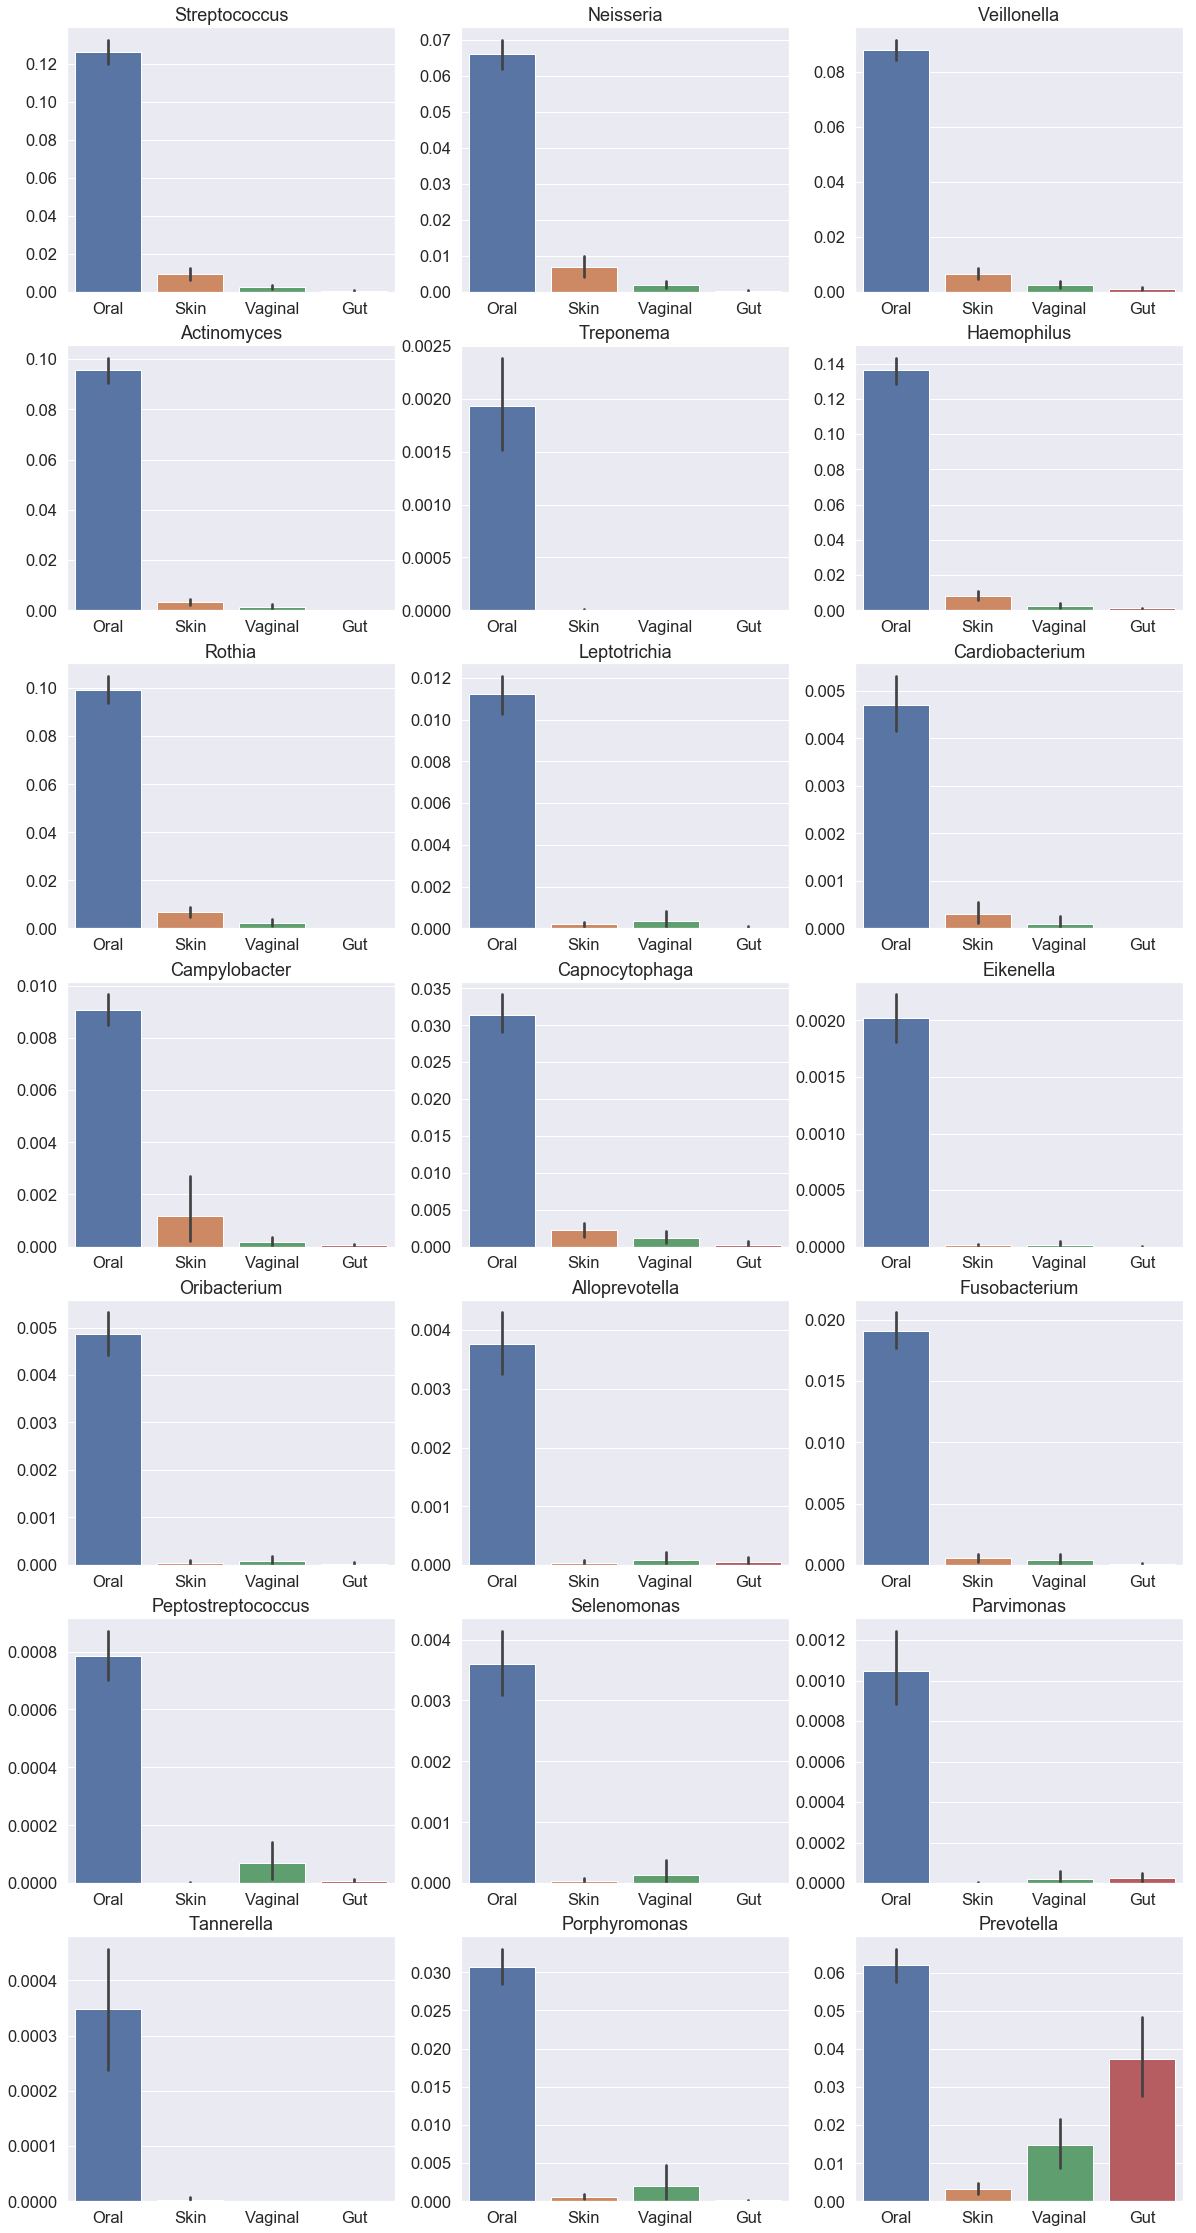

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 40))

sample_microb_names = ['Streptococcus', 'Neisseria', 'Veillonella', 'Actinomyces', 'Treponema', 'Haemophilus', 
                       'Rothia', 'Leptotrichia', 'Cardiobacterium', 'Campylobacter', 'Capnocytophaga', 
                       'Eikenella', 'Oribacterium', 'Alloprevotella', 'Fusobacterium', 'Peptostreptococcus', 
                       'Selenomonas', 'Parvimonas', 'Tannerella', 'Porphyromonas', 'Prevotella']

genus_index = [microb.columns.get_loc([i for i in microb.columns if ('g__' + j) in i][0]) 
               for j in sample_microb_names]

for i, ind in enumerate(genus_index):
    
    plt.subplot(7, 3, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(sample_microb_names[i])

plt.show()

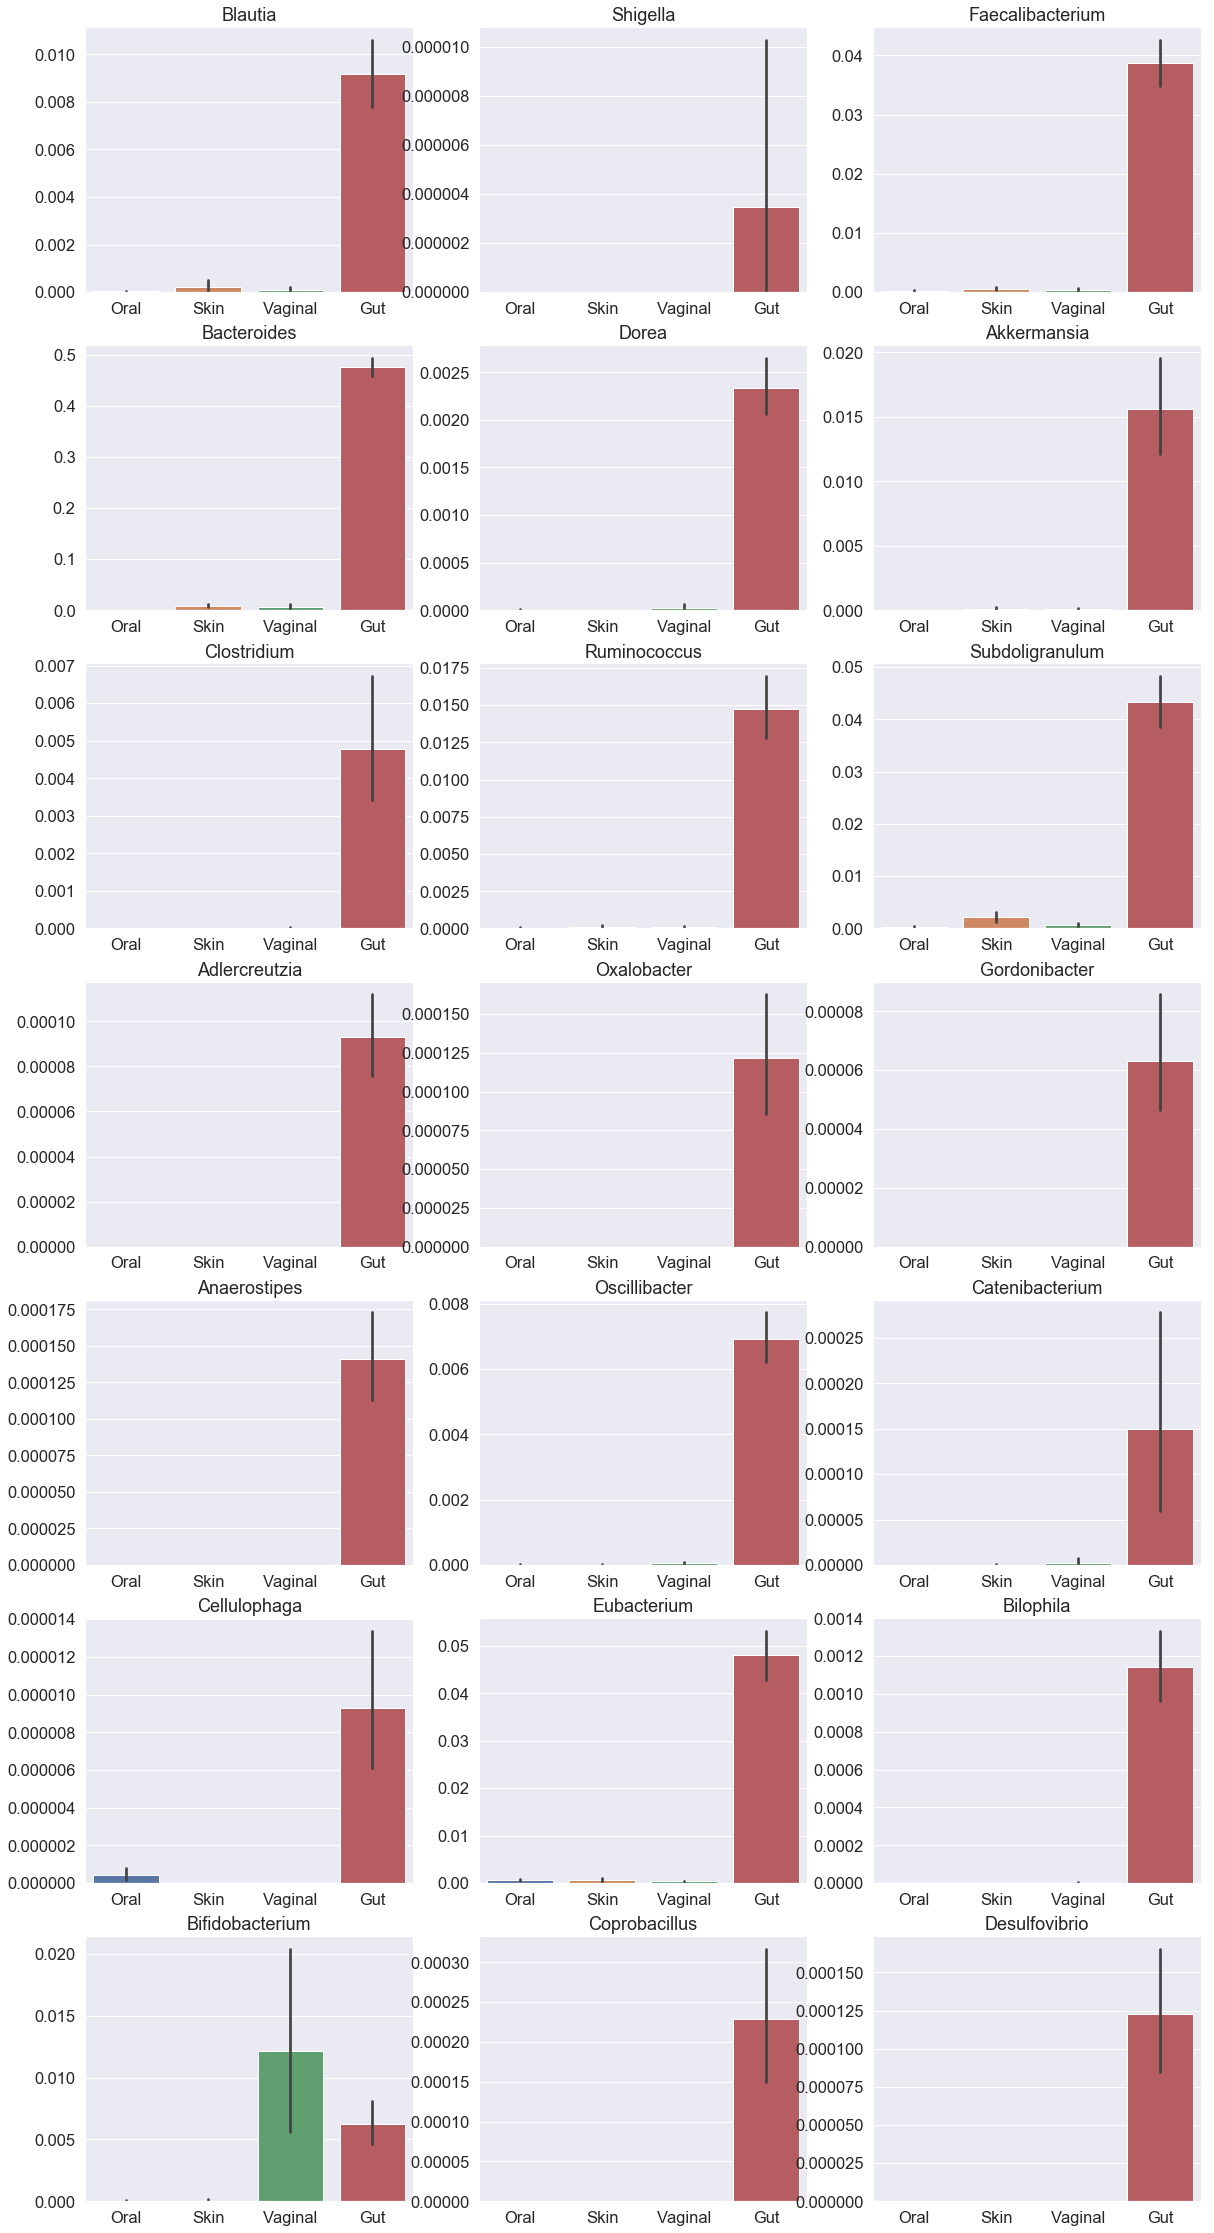

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 40))

sample_microb_names = ['Blautia', 'Shigella', 'Faecalibacterium', 'Bacteroides', 'Dorea', 'Akkermansia', 
                       'Clostridium', 'Ruminococcus', 'Subdoligranulum', 'Adlercreutzia', 'Oxalobacter', 
                       'Gordonibacter', 'Anaerostipes', 'Oscillibacter', 'Catenibacterium', 'Cellulophaga', 
                       'Eubacterium', 'Bilophila', 'Bifidobacterium', 'Coprobacillus', 'Desulfovibrio']

genus_index = [microb.columns.get_loc([i for i in microb.columns if ('g__' + j) in i][0]) 
               for j in sample_microb_names]

for i, ind in enumerate(genus_index):
    
    plt.subplot(7, 3, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(sample_microb_names[i])

plt.show()

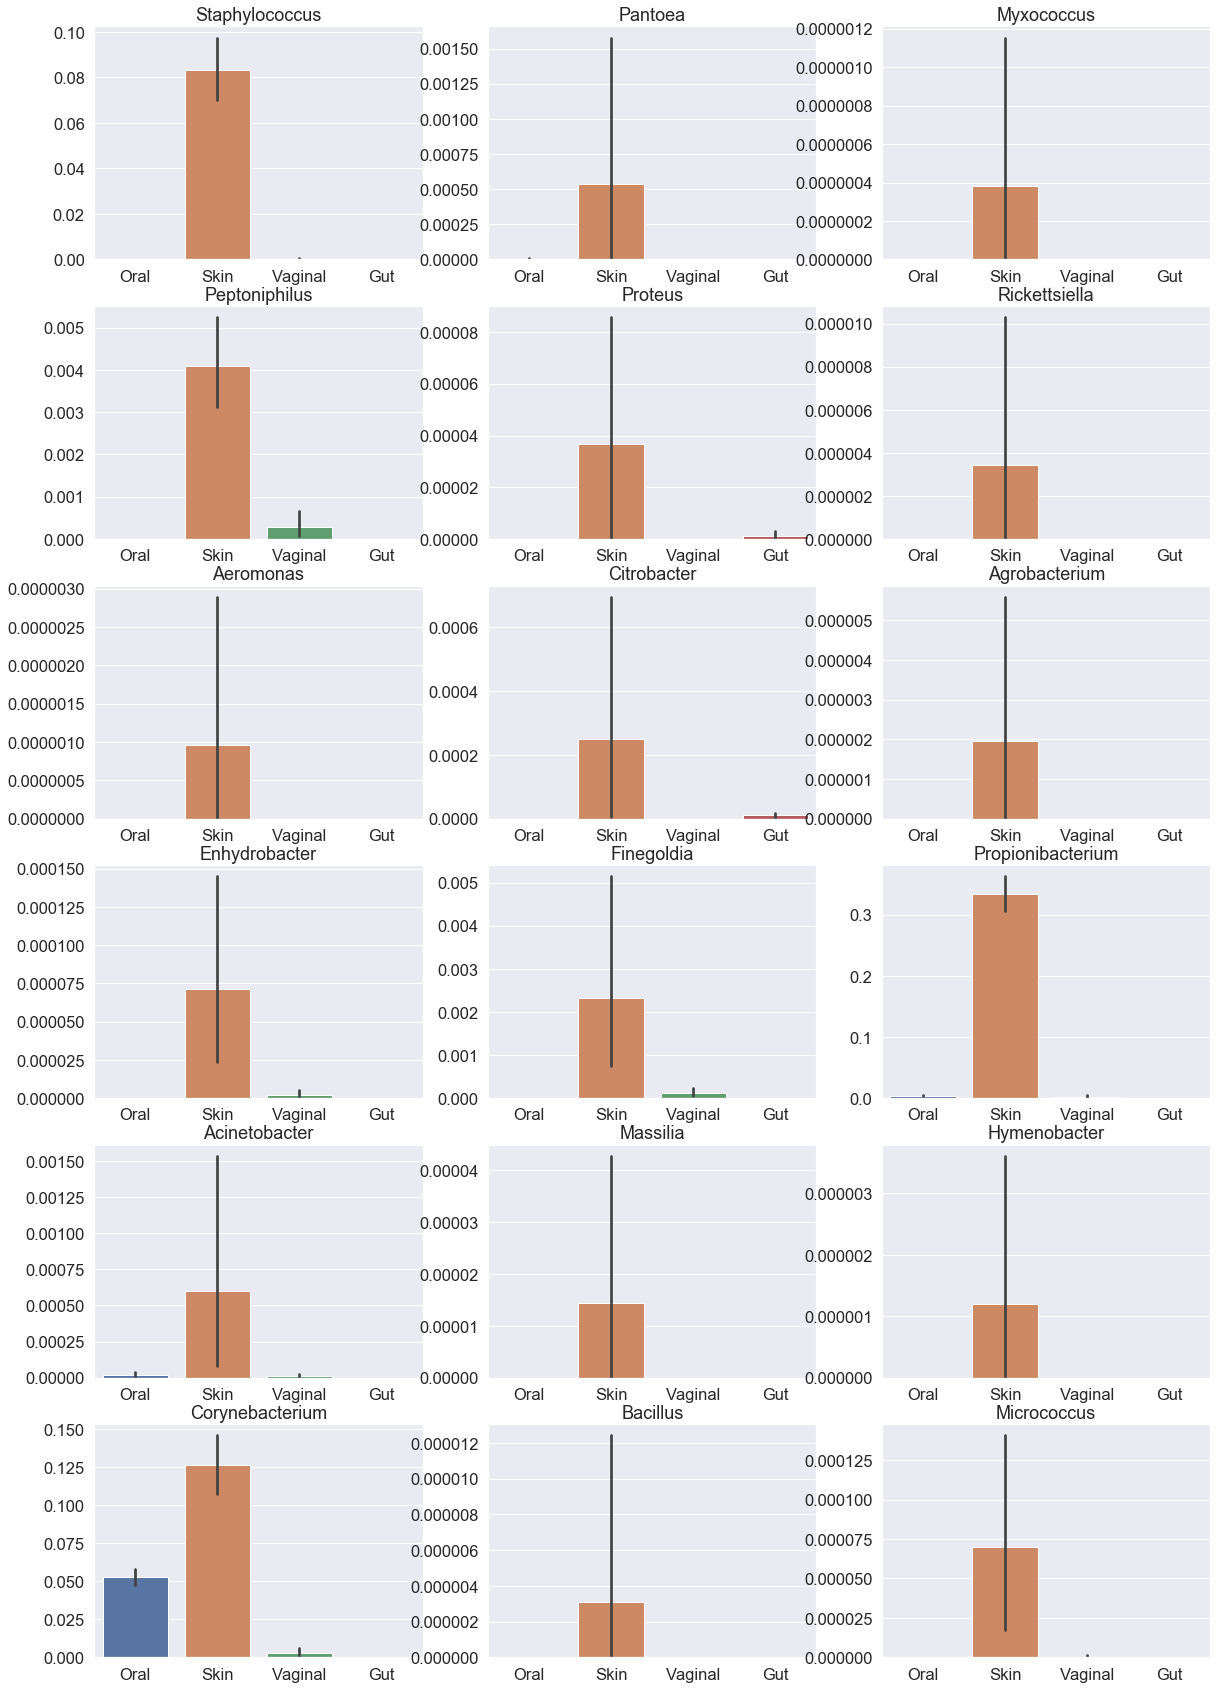

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 30))

sample_microb_names = ['Staphylococcus', 'Pantoea', 'Myxococcus', 'Peptoniphilus', 'Proteus', 
                       'Rickettsiella', 'Aeromonas', 'Citrobacter', 'Agrobacterium', 'Enhydrobacter', 
                       'Finegoldia', 'Propionibacterium', 'Acinetobacter', 'Massilia', 'Hymenobacter', 
                       'Corynebacterium', 'Bacillus', 'Micrococcus']

genus_index = [microb.columns.get_loc([i for i in microb.columns if ('g__' + j) in i][0]) 
               for j in sample_microb_names]

for i, ind in enumerate(genus_index):
    
    plt.subplot(6, 3, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(sample_microb_names[i])

plt.show()

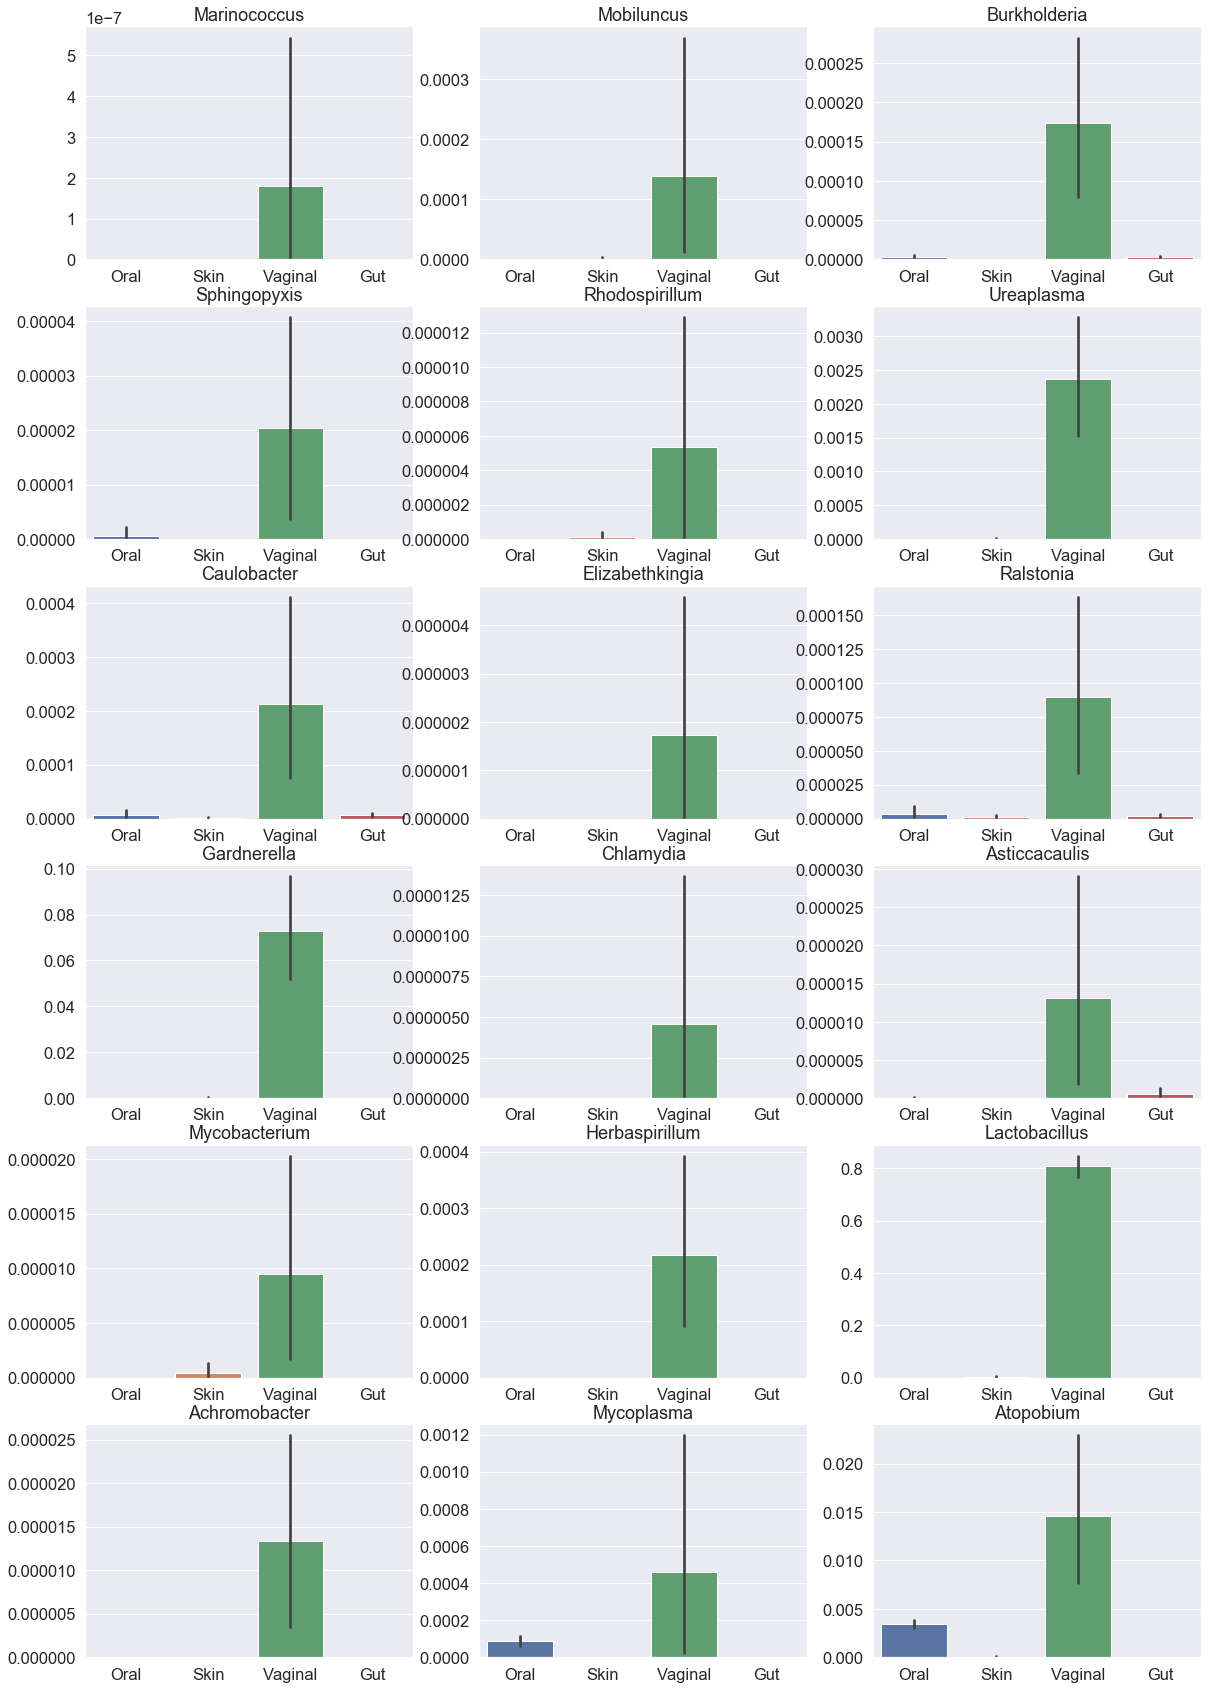

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 30))

sample_microb_names = ['Marinococcus', 'Mobiluncus', 'Burkholderia', 'Sphingopyxis', 'Rhodospirillum', 
                       'Ureaplasma', 'Caulobacter', 'Elizabethkingia', 'Ralstonia', 'Gardnerella', 'Chlamydia', 
                       'Asticcacaulis', 'Mycobacterium', 'Herbaspirillum', 'Lactobacillus', 'Achromobacter', 
                       'Mycoplasma', 'Atopobium']

genus_index = [microb.columns.get_loc([i for i in microb.columns if ('g__' + j) in i][0]) 
               for j in sample_microb_names]

for i, ind in enumerate(genus_index):
    
    plt.subplot(6, 3, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(sample_microb_names[i])

plt.show()

Let us select 3 the most tissue-specific genera from the 4 tissues:

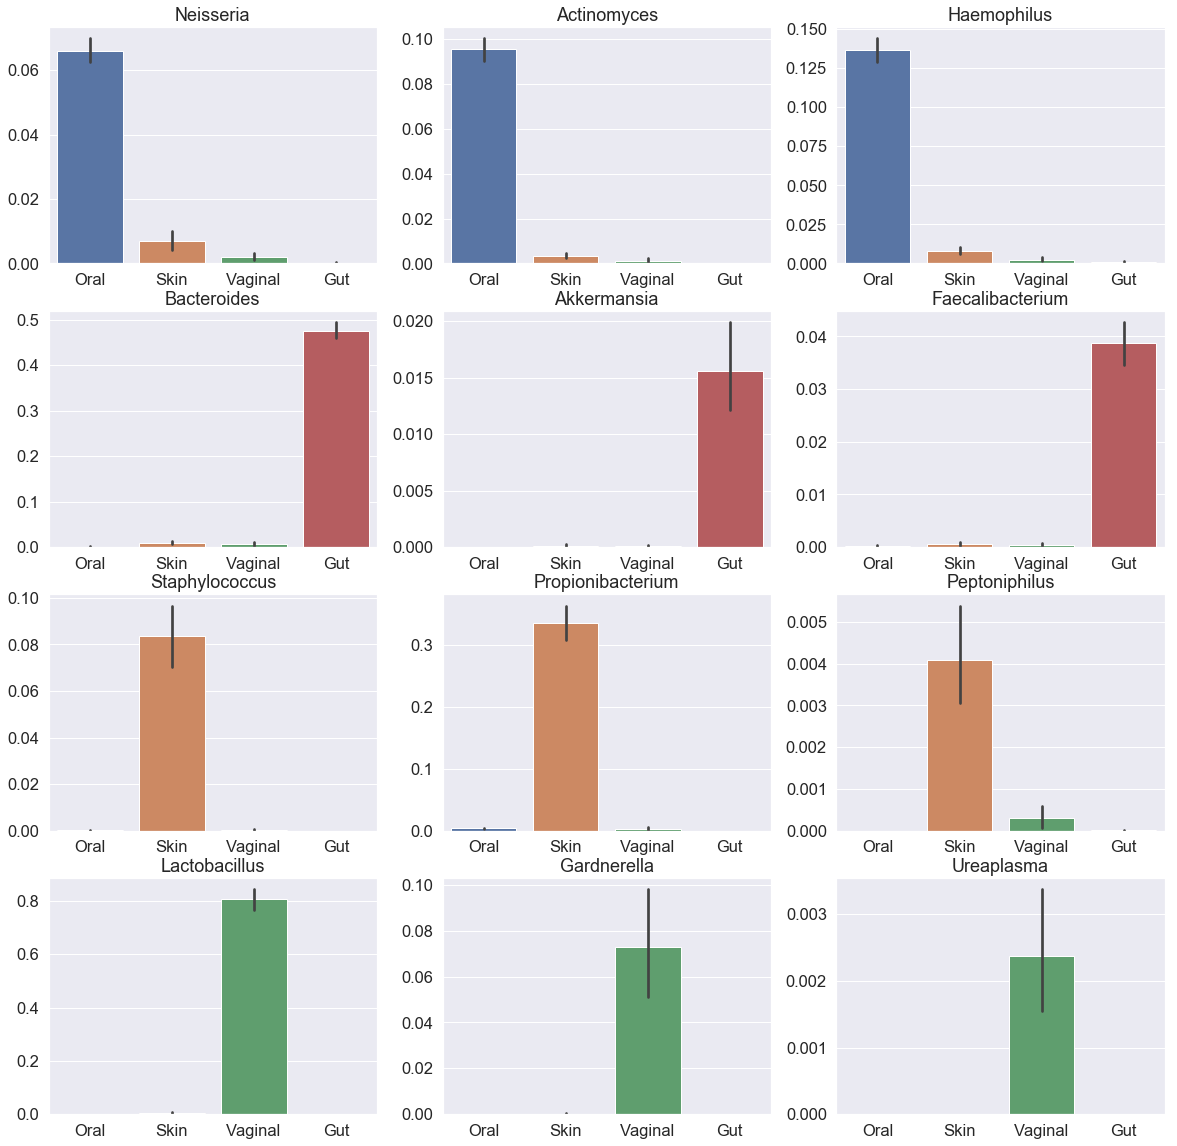

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize = (20, 20))

sample_microb_names = ['Neisseria', 'Actinomyces', 'Haemophilus', 
                       'Bacteroides', 'Akkermansia', 'Faecalibacterium', 
                       'Staphylococcus', 'Propionibacterium', 'Peptoniphilus', 
                       'Lactobacillus', 'Gardnerella', 'Ureaplasma']

genus_index = [microb.columns.get_loc([i for i in microb.columns if ('g__' + j) in i][0]) 
               for j in sample_microb_names]
for i, ind in enumerate(genus_index):
    
    plt.subplot(4, 3, i + 1)
    groupped_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                                 ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                                 ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                                 ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})
    sns.barplot(x = "Tissue", y = "Abundance", data = groupped_data)
    plt.xlabel("")
    plt.ylabel("")
    plt.title(sample_microb_names[i])

plt.show()

We can clearly see that there are a few very strong tissue-specific bacterial genera markers. Vagina had the least, i.e. 16 tissue-specific genera. However, taking a closer look one could see that it included such genera as **Burkholderia**, **Ralstonia**, **Bordetella** that are suspicious and are very likely to be PCR reagent contaminations. Therefore we carefully examined the list of the 16 vagina-specific bacterial genera and confidently concluded vaginal specificity for only 12 of them due to different reasons. In order not to bias the classification analysis, we will select 12 most tissue-specific markers from all the 4 tissues.

In [39]:
tis_spec_df = pd.DataFrame({'Oral': ['Neisseria', 'Veillonella', 'Actinomyces', 'Haemophilus', 'Rothia', 
                                     'Leptotrichia', 'Cardiobacterium', 'Capnocytophaga', 'Oribacterium', 
                                     'Alloprevotella', 'Gemella', 'Fusobacterium'], 
                            'Gut': ['Blautia', 'Faecalibacterium', 'Bacteroides', 'Dorea', 'Akkermansia', 
                                    'Clostridium', 'Ruminococcus', 'Subdoligranulum', 'Oxalobacter', 
                                    'Oscillibacter', 'Eubacterium', 'Bilophila'], 
                            'Skin': ['Staphylococcus', 'Peptoniphilus', 'Citrobacter', 'Enhydrobacter', 
                                     'Finegoldia', 'Propionibacterium', 'Acinetobacter', 'Massilia', 
                                     'Hymenobacter', 'Corynebacterium', 'Bacillus', 'Micrococcus'], 
                            'Vagina': ['Mobiluncus', 'Sphingopyxis', 'Ureaplasma', 'Caulobacter', 'Gardnerella', 
                                       'Chlamydia', 'Asticcacaulis', 'Mycobacterium', 'Herbaspirillum', 
                                       'Lactobacillus', 'Achromobacter', 'Atopobium']})
tis_spec_df

Oral               Gut               Skin          Vagina
0         Neisseria           Blautia     Staphylococcus      Mobiluncus
1       Veillonella  Faecalibacterium      Peptoniphilus    Sphingopyxis
2       Actinomyces       Bacteroides        Citrobacter      Ureaplasma
3       Haemophilus             Dorea      Enhydrobacter     Caulobacter
4            Rothia       Akkermansia         Finegoldia     Gardnerella
5      Leptotrichia       Clostridium  Propionibacterium       Chlamydia
6   Cardiobacterium      Ruminococcus      Acinetobacter   Asticcacaulis
7    Capnocytophaga   Subdoligranulum           Massilia   Mycobacterium
8      Oribacterium       Oxalobacter       Hymenobacter  Herbaspirillum
9    Alloprevotella     Oscillibacter    Corynebacterium   Lactobacillus
10          Gemella       Eubacterium           Bacillus   Achromobacter
11    Fusobacterium         Bilophila        Micrococcus       Atopobium

After a lot of thinking, we have **excluded Streptococcus from the list of oral-specific genera**. The reasons were explained above, i.e. if we grep reference genomes for Streptococcus, we will end up with too many "contaminating" sequences that originate from **gut-specific Streptococcus species**, however get erroneously assigned to oral microbiota if one assumes that streptococcus is an oral-specific genus.

The selected microbial genera can fairly well separate Oral, Gut, Skin and Vagina samples, let us run a quick clustering based on Spearman correlation distance between the samples and using the 48 selected microbial genera.

In [46]:
microb_genus = microb
microb_genus.columns = [i.split('|')[5] for i in microb_genus.columns]
microb_genus.columns = [i.replace('g__','') for i in microb_genus.columns]
microb_genus

Granulicella  Terriglobus  Actinobaculum  Actinomyces  Mobiluncus  \
SRS011061           0.0          0.0       0.000000     0.000000         0.0   
SRS011084           0.0          0.0       0.000000     0.000000         0.0   
SRS011086           0.0          0.0       0.000061     0.117511         0.0   
SRS011090           0.0          0.0       0.000000     0.027362         0.0   
SRS011098           0.0          0.0       0.014371     0.118618         0.0   
...                 ...          ...            ...          ...         ...   
SRS971275           0.0          0.0       0.000000     0.000000         0.0   
SRS971276           0.0          0.0       0.000000     0.000000         0.0   
SRS971277           0.0          0.0       0.000000     0.027179         0.0   
SRS971427           0.0          0.0       0.000000     0.000000         0.0   
SRS971428           0.0          0.0       0.000000     0.000000         0.0   

           Varibaculum  Brevibacterium  Cellulomonas  Corynebacterium  \
SRS011061          0.0        0.000000           0.0         0.000000   
SRS011084          0.0        0.000000           0.0         0.000000   
SRS011086          0.0        0.000195           0.0         0.000035   
SRS011090          0.0        0.000000           0.0         0.000056   
SRS011098          0.0        0.000029           0.0         0.131278   
...                ...             ...           ...              ...   
SRS971275          0.0        0.000000           0.0         0.000000   
SRS971276          0.0        0.000000           0.0         0.000000   
SRS971277          0.0        0.000051           0.0         0.000000   
SRS971427          0.0        0.000000           0.0         0.120302   
SRS971428          0.0        0.000000           0.0         0.080204   

           Turicella  ...  Brachyspira  Treponema  Fretibacterium  \
SRS011061        0.0  ...          0.0   0.000000             0.0   
SRS011084        0.0  ...          0.0   0.000000             0.0   
SRS011086        0.0  ...          0.0   0.000000             0.0   
SRS011090        0.0  ...          0.0   0.000000             0.0   
SRS011098        0.0  ...          0.0   0.000004             0.0   
...              ...  ...          ...        ...             ...   
SRS971275        0.0  ...          0.0   0.000000             0.0   
SRS971276        0.0  ...          0.0   0.000000             0.0   
SRS971277        0.0  ...          0.0   0.000008             0.0   
SRS971427        0.0  ...          0.0   0.000000             0.0   
SRS971428        0.0  ...          0.0   0.000000             0.0   

           Jonquetella  Pyramidobacter  Synergistes  Candidatus_Phytoplasma  \
SRS011061          0.0             0.0          0.0                     0.0   
SRS011084          0.0             0.0          0.0                     0.0   
SRS011086          0.0             0.0          0.0                     0.0   
SRS011090          0.0             0.0          0.0                     0.0   
SRS011098          0.0             0.0          0.0                     0.0   
...                ...             ...          ...                     ...   
SRS971275          0.0             0.0          0.0                     0.0   
SRS971276          0.0             0.0          0.0                     0.0   
SRS971277          0.0             0.0          0.0                     0.0   
SRS971427          0.0             0.0          0.0                     0.0   
SRS971428          0.0             0.0          0.0                     0.0   

           Mycoplasma  Ureaplasma  Akkermansia  
SRS011061         0.0         0.0     0.003018  
SRS011084         0.0         0.0     0.003518  
SRS011086         0.0         0.0     0.000000  
SRS011090         0.0         0.0     0.000000  
SRS011098         0.0         0.0     0.000000  
...               ...         ...          ...  
SRS971275         0.0         0.0     0.001905  
SRS

In [62]:
gen_list = ['Neisseria', 'Veillonella', 'Actinomyces', 'Haemophilus', 'Rothia', 'Leptotrichia', 'Cardiobacterium', 
            'Capnocytophaga', 'Oribacterium', 'Alloprevotella', 'Fusobacterium', 'Blautia', 'Faecalibacterium', 
            'Bacteroides', 'Dorea', 'Akkermansia', 'Clostridium', 'Ruminococcus', 'Subdoligranulum', 
            'Oxalobacter', 'Oscillibacter', 'Eubacterium', 'Bilophila', 'Staphylococcus', 'Peptoniphilus', 
            'Citrobacter', 'Enhydrobacter', 'Finegoldia', 'Propionibacterium', 'Acinetobacter', 'Massilia', 
            'Hymenobacter', 'Corynebacterium', 'Bacillus', 'Micrococcus', 'Mobiluncus', 'Sphingopyxis', 
            'Ureaplasma', 'Caulobacter', 'Gardnerella', 'Chlamydia', 'Asticcacaulis', 'Mycobacterium', 
            'Herbaspirillum', 'Lactobacillus', 'Achromobacter', 'Atopobium']
print(gen_list)

['Neisseria', 'Veillonella', 'Actinomyces', 'Haemophilus', 'Rothia', 'Leptotrichia', 'Cardiobacterium', 'Capnocytophaga', 'Oribacterium', 'Alloprevotella', 'Fusobacterium', 'Blautia', 'Faecalibacterium', 'Bacteroides', 'Dorea', 'Akkermansia', 'Clostridium', 'Ruminococcus', 'Subdoligranulum', 'Oxalobacter', 'Oscillibacter', 'Eubacterium', 'Bilophila', 'Staphylococcus', 'Peptoniphilus', 'Citrobacter', 'Enhydrobacter', 'Finegoldia', 'Propionibacterium', 'Acinetobacter', 'Massilia', 'Hymenobacter', 'Corynebacterium', 'Bacillus', 'Micrococcus', 'Mobiluncus', 'Sphingopyxis', 'Ureaplasma', 'Caulobacter', 'Gardnerella', 'Chlamydia', 'Asticcacaulis', 'Mycobacterium', 'Herbaspirillum', 'Lactobacillus', 'Achromobacter', 'Atopobium']


In [63]:
microb_genus_selected = microb_genus[gen_list]
print(microb_genus_selected.shape)
microb_genus_selected

(2355, 47)


Neisseria  Veillonella  Actinomyces  Haemophilus    Rothia  \
SRS011061   0.000000     0.000676     0.000000     0.000350  0.000000   
SRS011084   0.000000     0.000074     0.000000     0.000140  0.000000   
SRS011086   0.000580     0.111812     0.117511     0.039997  0.122279   
SRS011090   0.028027     0.039875     0.027362     0.197183  0.038528   
SRS011098   0.004748     0.011116     0.118618     0.031137  0.444377   
...              ...          ...          ...          ...       ...   
SRS971275   0.000000     0.000000     0.000000     0.000000  0.000000   
SRS971276   0.000000     0.000918     0.000000     0.001092  0.000000   
SRS971277   0.001009     0.108100     0.027179     0.257675  0.351003   
SRS971427   0.000000     0.000000     0.000000     0.000000  0.000084   
SRS971428   0.000000     0.000000     0.000000     0.000000  0.000000   

           Leptotrichia  Cardiobacterium  Capnocytophaga  Oribacterium  \
SRS011061      0.000000         0.000000        0.000000      0.000000   
SRS011084      0.000000         0.000000        0.000000      0.000000   
SRS011086      0.001147         0.000034        0.000562      0.008408   
SRS011090      0.019240         0.000082        0.030566      0.000000   
SRS011098      0.006427         0.014847        0.068869      0.000224   
...                 ...              ...             ...           ...   
SRS971275      0.000000         0.000000        0.000000      0.000000   
SRS971276      0.000000         0.000000        0.000000      0.000000   
SRS971277      0.000088         0.000035        0.001030      0.002810   
SRS971427      0.000000         0.000000        0.000000      0.000000   
SRS971428      0.000000         0.000000        0.000000      0.000000   

           Alloprevotella  ...  Ureaplasma  Caulobacter  Gardnerella  \
SRS011061        0.000000  ...         0.0          0.0     0.000000   
SRS011084        0.000000  ...         0.0          0.0     0.000000   
SRS011086        0.000006  ...         0.0          0.0     0.000000   
SRS011090        0.002879  ...         0.0          0.0     0.000000   
SRS011098        0.000058  ...         0.0          0.0     0.000000   
...                   ...  ...         ...          ...          ...   
SRS971275        0.000027  ...         0.0          0.0     0.000000   
SRS971276        0.000000  ...         0.0          0.0     0.000000   
SRS971277        0.000024  ...         0.0          0.0     0.000000   
SRS971427        0.000000  ...         0.0          0.0     0.000000   
SRS971428        0.000167  ...         0.0          0.0     0.004806   

           Chlamydia  Asticcacaulis  Mycobacterium  Herbaspirillum  \
SRS011061        0.0            0.0            0.0             0.0   
SRS011084        0.0            0.0            0.0             0.0   
SRS011086        0.0            0.0            0.0             0.0   
SRS011090        0.0            0.0            0.0             0.0   
SRS011098        0.0            0.0            0.0             0.0   
...              ...            ...            ...             ...   
SRS971275        0.0            0.0            0.0             0.0   
SRS971276        0.0            0.0            0.0             0.0   
SRS971277        0.0            0.0            0.0             0.0   
SRS971427        0.0            0.0            0.0             0.0   
SRS971428        0.0            0.0            0.0             0.0   

           Lactobacillus  Achromobacter  Atopobium  
SRS011061       0.000000            0.0   0.000000  
SRS011084       0.000000            0.0   0.000000  
SRS011086       0.000181            0.0   0.002290  
SRS011090       0.041174            0.0   0.000000  
SRS011098       0.000039            0.0   0.000047  
...                  ...            ...        ...  
SRS971275       0.000000            0.0   0.000000  
SRS971276       0.000000            0.0   0.000000  
SRS971277       0.000000            0.0   0.000686  
SRS971427

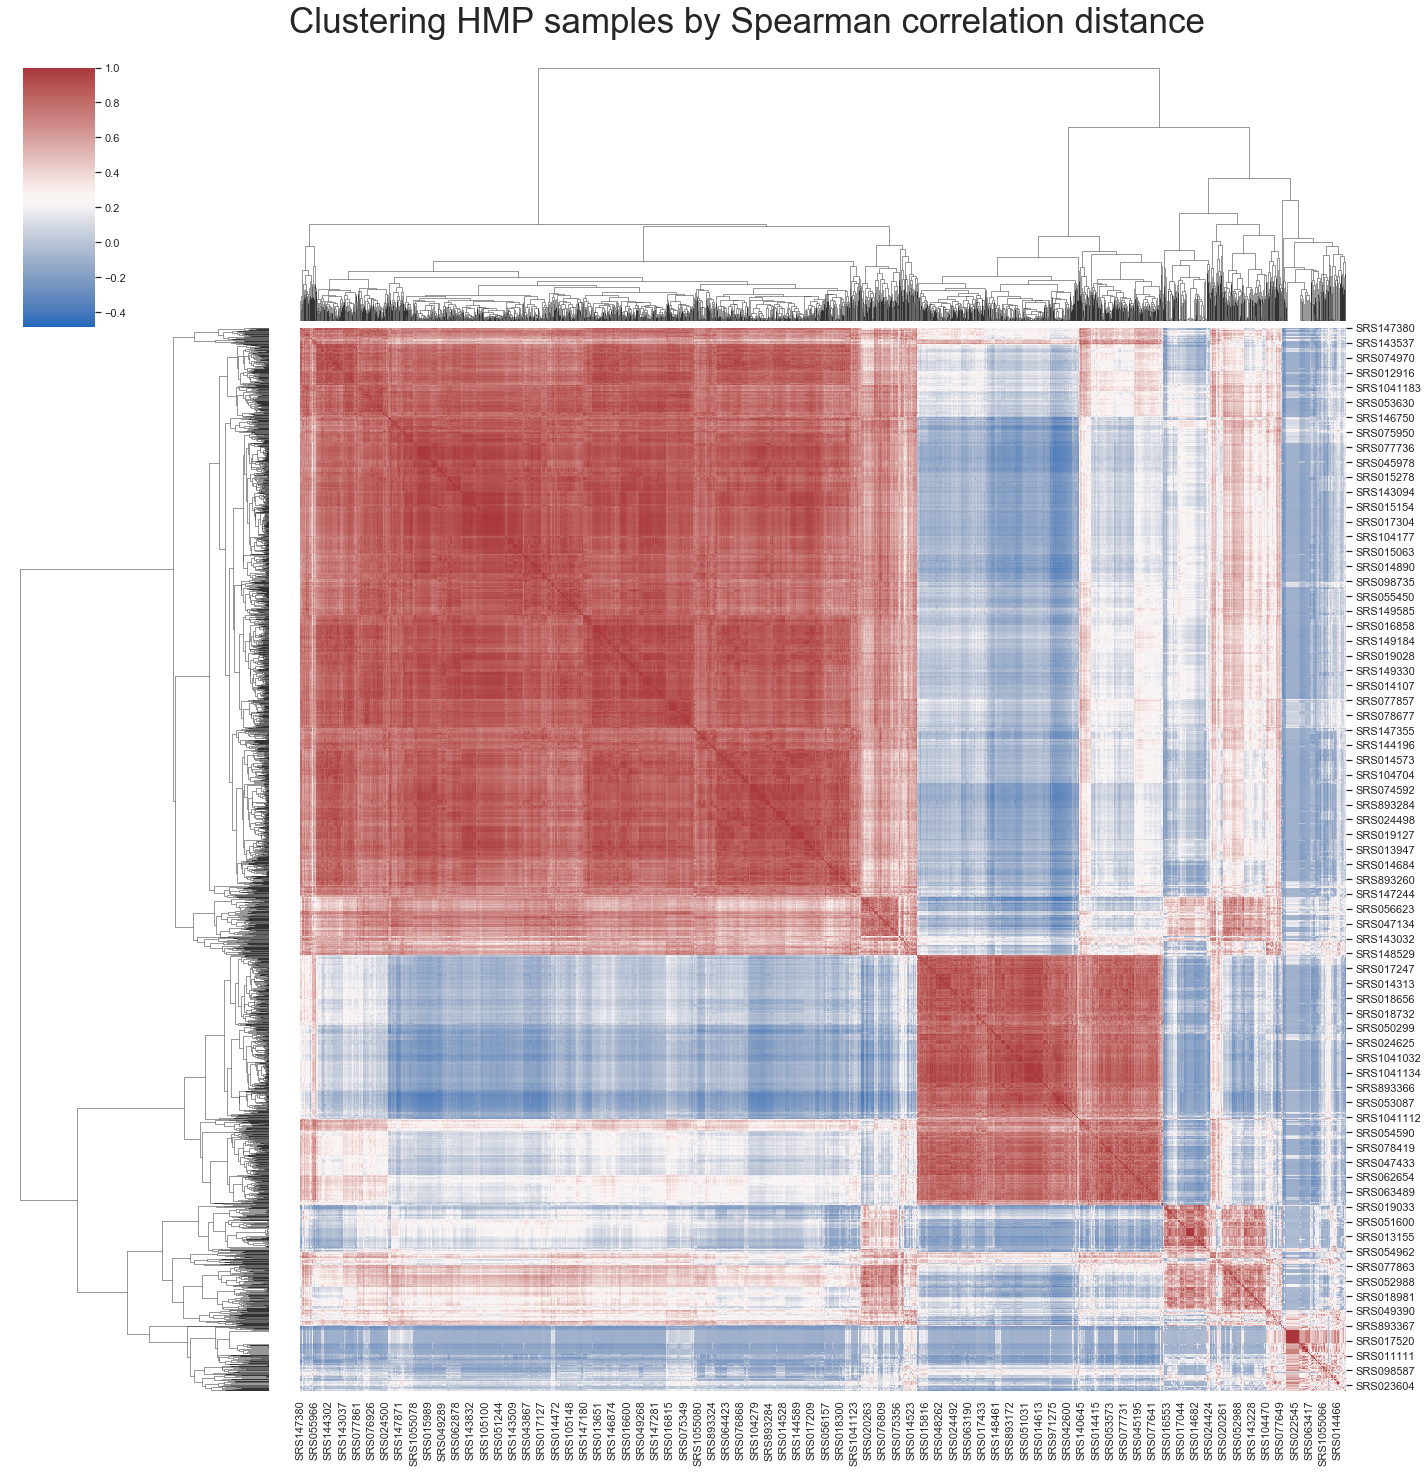

In [88]:
import scipy as sp
import seaborn as sns

sns.set(font_scale = 1)

rho, _ = sp.stats.spearmanr(microb_genus_selected.T)
rho = pd.DataFrame(rho, index = microb_genus_selected.index, columns = microb_genus_selected.index)
sns.clustermap(rho, cmap = 'vlag', figsize = (20, 20))
plt.text(5, 1.2,'Clustering HMP samples by Spearman correlation distance', fontsize = 35)

plt.show()

We clearly observe 4 clusters corresponding to the Oral, Gut, Skin and Vagina samples from the HMP project. The largest cluster are the Oral samples. The second largest cluster are corresponds to the Gut HMP samples.

Now we are going to use the names of the tissue-specific genera for extracting reference genome (fasta-files) IDs from the list of microbe names. For this purpose, we will be using the match-file MapBactName2ID.txt that looks as follows:

In [41]:
!head MapBactName2ID.txt

GCF_000005825.2_ASM582v2_genomic.fna.gz	>NC_013791.2 Bacillus pseudofirmus OF4, complete sequence
GCF_000005845.2_ASM584v2_genomic.fna.gz	>NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome
GCF_000006605.1_ASM660v1_genomic.fna.gz	>NC_007164.1 Corynebacterium jeikeium K411, complete sequence
GCF_000006625.1_ASM662v1_genomic.fna.gz	>NC_002162.1 Ureaplasma parvum serovar 3 str. ATCC 700970, complete sequence
GCF_000006645.1_ASM664v1_genomic.fna.gz	>NC_004088.1 Yersinia pestis KIM10+, complete sequence
GCF_000006685.1_ASM668v1_genomic.fna.gz	>NC_002620.2 Chlamydia muridarum str. Nigg, complete sequence
GCF_000006725.1_ASM672v1_genomic.fna.gz	>NC_002488.3 Xylella fastidiosa 9a5c, complete sequence
GCF_000006745.1_ASM674v1_genomic.fna.gz	>NC_002505.1 Vibrio cholerae O1 biovar El Tor str. N16961 chromosome I, complete sequence
GCF_000006765.1_ASM676v1_genomic.fna.gz	>NC_002516.2 Pseudomonas aeruginosa PAO1, complete genome
GCF_000006785.2_ASM678v2_genomic.fna.gz	>NC_002737

The file The MapBactName2ID.txt was built by extracting headers of the reference genomes and matching their file names (GCF-ids) with the headers. In my previous post [here](https://towardsdatascience.com/plague-in-ancient-and-modern-dna-f8e52e3d8a11) I showed how to download the reference genomes from the NCBI RefSeq database. Briefly the procedure is described here:

In [42]:
#wget ftp://ftp.ncbi.nlm.nih.gov/genomes/refseq/bacteria/assembly_summary.txt
#grep 'Complete Genome' assembly_summary.txt \
#> assembly_summary_complete_latest_reference_genomes.txt
#awk -F "\t" '$12=="Complete Genome" && $11=="latest"{print $20}' assembly_summary.txt \
#> assembly_summary_complete_latest_reference_genomes_paths.txt

#mkdir BacterialGenomes
#for i in $(cat assembly_summary_complete_latest_reference_genomes_paths.txt)
#do 
#wget -P BacterialGenomes ${i}/*genomic.fna.gz
#done

Now we are going to use the lists of the tissue-specific genera and simply grep the records from the MapBactName2ID.txt file that contain the matching reference genome IDs. Here we display a few lines of the results of grepping of FASTA reference genome IDs for the 12 selected oral, gut, skin and vagina-specific genera.

In [43]:
!grep -wFf tissue_specific_genera_names_oral_12genera.txt MapBactName2ID.txt | head

GCF_000006845.1_ASM684v1_genomic.fna.gz	>NC_002946.2 Neisseria gonorrhoeae FA 1090, complete sequence
GCF_000007945.1_ASM794v1_genomic.fna.gz	>NC_002940.2 [Haemophilus] ducreyi 35000HP, complete sequence
GCF_000008805.1_ASM880v1_genomic.fna.gz	>NC_003112.2 Neisseria meningitidis MC58, complete sequence
GCF_000009105.1_ASM910v1_genomic.fna.gz	>NC_003116.1 Neisseria meningitidis Z2491, complete sequence
GCF_000009465.1_ASM946v1_genomic.fna.gz	>NC_008767.1 Neisseria meningitidis FAM18, complete sequence
GCF_000011025.1_ASM1102v1_genomic.fna.gz	>NC_013715.1 Rothia mucilaginosa DY-18, complete sequence
GCF_000012185.1_ASM1218v1_genomic.fna.gz	>NC_007146.2 Haemophilus influenzae 86-028NP, complete sequence
GCF_000014105.1_ASM1410v1_genomic.fna.gz	>NC_010120.1 Neisseria meningitidis 053442, complete sequence
GCF_000020105.1_ASM2010v1_genomic.fna.gz	>NC_011035.1 Neisseria gonorrhoeae NCCP11945, complete sequence
GCF_000023285.1_ASM2328v1_genomic.fna.gz	>NC_013162.1 Capnocytophaga ochracea DSM 

In [44]:
!grep -wFf tissue_specific_genera_names_gut_12genera.txt MapBactName2ID.txt | head

GCF_000007625.1_ASM762v1_genomic.fna.gz	>NC_004557.1 Clostridium tetani E88, complete sequence
GCF_000008765.1_ASM876v1_genomic.fna.gz	>NC_003030.1 Clostridium acetobutylicum ATCC 824, complete sequence
GCF_000009685.1_ASM968v1_genomic.fna.gz	>NC_003366.1 Clostridium perfringens str. 13, complete sequence
GCF_000009925.1_ASM992v1_genomic.fna.gz	>NC_006347.1 Bacteroides fragilis YCH46, complete sequence
GCF_000010265.1_ASM1026v1_genomic.fna.gz	>NC_011837.1 Clostridium kluyveri NBRC 12016, complete sequence
GCF_000011065.1_ASM1106v1_genomic.fna.gz	>NC_004663.1 Bacteroides thetaiotaomicron VPI-5482, complete sequence
GCF_000012825.1_ASM1282v1_genomic.fna.gz	>NC_009614.1 Bacteroides vulgatus ATCC 8482, complete sequence
GCF_000013285.1_ASM1328v1_genomic.fna.gz	>NC_008261.1 Clostridium perfringens ATCC 13124, complete sequence
GCF_000014125.1_ASM1412v1_genomic.fna.gz	>NC_008593.1 Clostridium novyi NT, complete sequence
GCF_000016505.1_ASM1650v1_genomic.fna.gz	>NC_009706.1 Clostridium kluyve

In [45]:
!grep -wFf tissue_specific_genera_names_skin_12genera.txt MapBactName2ID.txt | head

GCF_000005825.2_ASM582v2_genomic.fna.gz	>NC_013791.2 Bacillus pseudofirmus OF4, complete sequence
GCF_000006605.1_ASM660v1_genomic.fna.gz	>NC_007164.1 Corynebacterium jeikeium K411, complete sequence
GCF_000007645.1_ASM764v1_genomic.fna.gz	>NC_004461.1 Staphylococcus epidermidis ATCC 12228, complete sequence
GCF_000007825.1_ASM782v1_genomic.fna.gz	>NC_004722.1 Bacillus cereus ATCC 14579, complete sequence
GCF_000007845.1_ASM784v1_genomic.fna.gz	>NC_003997.3 Bacillus anthracis str. Ames, complete sequence
GCF_000008005.1_ASM800v1_genomic.fna.gz	>NC_003909.8 Bacillus cereus ATCC 10987, complete sequence
GCF_000008165.1_ASM816v1_genomic.fna.gz	>NC_005945.1 Bacillus anthracis str. Sterne, complete sequence
GCF_000008425.1_ASM842v1_genomic.fna.gz	>NC_006322.1 Bacillus licheniformis DSM 13 = ATCC 14580, complete sequence
GCF_000008445.1_ASM844v1_genomic.fna.gz	>NC_007530.2 Bacillus anthracis str. 'Ames Ancestor', complete sequence
GCF_000008505.1_ASM850v1_genomic.fna.gz	>NC_005957.1 [Bacillu

In [46]:
!grep -wFf tissue_specific_genera_names_vagina_12genera.txt MapBactName2ID.txt | head

GCF_000006625.1_ASM662v1_genomic.fna.gz	>NC_002162.1 Ureaplasma parvum serovar 3 str. ATCC 700970, complete sequence
GCF_000006685.1_ASM668v1_genomic.fna.gz	>NC_002620.2 Chlamydia muridarum str. Nigg, complete sequence
GCF_000006905.1_ASM690v1_genomic.fna.gz	>NC_002696.2 Caulobacter vibrioides CB15, complete sequence
GCF_000007205.1_ASM720v1_genomic.fna.gz	>NC_005043.1 Chlamydia pneumoniae TW-183, complete sequence
GCF_000007605.1_ASM760v1_genomic.fna.gz	>NC_003361.3 Chlamydia caviae GPIC, complete sequence
GCF_000007865.1_ASM786v1_genomic.fna.gz	>NC_002944.2 Mycobacterium avium subsp. paratuberculosis K-10, complete sequence
GCF_000008065.1_ASM806v1_genomic.fna.gz	>NC_005362.1 Lactobacillus johnsonii NCC 533, complete sequence
GCF_000008585.1_ASM858v1_genomic.fna.gz	>NC_002755.2 Mycobacterium tuberculosis CDC1551, complete sequence
GCF_000008725.1_ASM872v1_genomic.fna.gz	>NC_000117.1 Chlamydia trachomatis D/UW-3/CX chromosome, complete genome
GCF_000008745.1_ASM874v1_genomic.fna.gz	>N

In [47]:
!grep -wFf tissue_specific_genera_names_oral_12genera.txt MapBactName2ID.txt > tissue_specific_fasta_IDs_oral.txt

In [48]:
!grep -wFf tissue_specific_genera_names_gut_12genera.txt MapBactName2ID.txt > tissue_specific_fasta_IDs_gut.txt

In [49]:
!grep -wFf tissue_specific_genera_names_skin_12genera.txt MapBactName2ID.txt > tissue_specific_fasta_IDs_skin.txt

In [50]:
!grep -wFf tissue_specific_genera_names_vagina_12genera.txt MapBactName2ID.txt>tissue_specific_fasta_IDs_vagina.txt

### Preparing Data for CNN Classifier <a class="anchor" id="Preparing-Data-for-CNN-Classifier"></a>

Now when we have reference genome (fasta-files) IDs corresponding to tissue-specific genera, we can slice the reference genomes and create 4 sets of sequences (for example 80 nt long) with the labels 0, 1, 2 and 3 corresponding to oral, gut, skin and vagin microbial genera. In the loop below, we first read the files with fasta IDs for each of the 4 tissues, then for each of the fasta IDs we read the fasta files and select random 1000 sequences of length 80 nt. We will also on the fly drop sequences that contain 'N' nucleotide and restrict ourselves to only 'A', 'C', 'T' and 'G' containing sequences.

In [51]:
import pandas as pd
fasta_df = pd.read_csv('tissue_specific_fasta_IDs_oral.txt', header = None, sep = '\t')
fasta_df

0  \
0                       GCF_000006845.1_ASM684v1_genomic.fna.gz   
1                       GCF_000007945.1_ASM794v1_genomic.fna.gz   
2                       GCF_000008805.1_ASM880v1_genomic.fna.gz   
3                       GCF_000009105.1_ASM910v1_genomic.fna.gz   
4                       GCF_000009465.1_ASM946v1_genomic.fna.gz   
..                                                          ...   
470  GCF_900683735.1_Fusobacterium_ulcerans_81A6_genomic.fna.gz   
471                    GCF_901472485.1_35860_G01_genomic.fna.gz   
472                    GCF_901482445.1_45076_H02_genomic.fna.gz   
473         GCF_902381645.1_UHGG_MGYG-HGUT-01347_genomic.fna.gz   
474                        GCF_902810435.1_SKV38_genomic.fna.gz   

                                                                                                     1  
0                                        >NC_002946.2 Neisseria gonorrhoeae FA 1090, complete sequence  
1                                        >NC_002940.2 [Haemophilus] ducreyi 35000HP, complete sequence  
2                                          >NC_003112.2 Neisseria meningitidis MC58, complete sequence  
3                                         >NC_003116.1 Neisseria meningitidis Z2491, complete sequence  
4                                         >NC_008767.1 Neisseria meningitidis FAM18, complete sequence  
..                                                                                                 ...  
470  >NZ_LR215979.1 Fusobacterium ulcerans ATCC 49185 isolate Fusobacterium ulcerans 81A6 chromosome 1  
471                                 >NZ_LR590465.1 Haemophilus influenzae strain NCTC8468 chromosome 1  
472                                   >NZ_LR590477.1 Neisseria lactamica strain NCTC10617 chromosome 1  
473                        >NZ_LR698955.1 Fusobacterium nucleatum isolate MGYG-HGUT-01347 chromosome 1  
474                    >NZ_LR778174.1 Veillonella parvula strain SKV38 chromosome 1, complete sequence  

[475 rows x 2 columns]

In [52]:
import gzip
import random
import pandas as pd

nt = 80 # length of each sequence
Nseq = 3000 # number of randomly drawn sequences from each fasta-file
random.seed(123)

all_tissues_seqs = []
all_tissues_labs = []
for lab, tissue in enumerate(['oral', 'gut', 'skin', 'vagina']):
    
    print('Working with tissue: {} ************************************************'.format(tissue))
    fasta_df = pd.read_csv('tissue_specific_fasta_IDs_' + tissue + '.txt', header = None, sep = '\t')

    tissue_seqs = []
    for i in range(fasta_df.shape[0]):

        with gzip.open('/home/nikolay/Documents/Medium/DeepLearningMetagenomics/BacterialGenomes/' 
                       + fasta_df[0][i], 'r') as f:
            content = f.readlines()
            del content[0]
        
            random_seqs = random.sample(content, Nseq)
            random_seqs = [j.rstrip()[0:nt].decode() for j in random_seqs]
            random_seqs = [k for k in random_seqs if 
                           k.count('A') > 0 and k.count('C') > 0 and k.count('G') > 0 and k.count('T') > 0 
                           and len(list(k)) == nt and 'N' not in k and 'H' not in k and 'K' not in k 
                           and 'M' not in k and 'R' not in k and 'S' not in k and 'V' not in k 
                           and 'W' not in k and 'Y' not in k and 'B' not in k]
        
            tissue_seqs = tissue_seqs + random_seqs
        
            if((i + 1) % 500 == 0):
                print('Finished {} fasta-files'.format(i + 1))
    
    all_tissues_seqs = all_tissues_seqs + tissue_seqs
    print(all_tissues_seqs[(len(all_tissues_seqs)-3):len(all_tissues_seqs)])
    all_tissues_labs = all_tissues_labs + [lab]*len(tissue_seqs)
    print(all_tissues_labs[(len(all_tissues_labs)-3):len(all_tissues_labs)])

Working with tissue: oral ************************************************
['ATGATCAATACTATCCGTATTAGGTACATCAAACAAATTAAAATCATTAATACAAGTATGATATGAGGACTCCATTAATC', 'AGCTGAAGCTCAACGTCAAGCGGCTATTAGAGCGGAACAAGAACGTATCGCCGCTCAACAAGCCGAAGCGCAACGTCAAG', 'TGACTCTGATTCATCGCAACATTTCGGCCTTCCCAGTTTCCCAGTGACCCTATAATGAAACCTTGCTCCTCATTACAGCT']
[0, 0, 0]
Working with tissue: gut ************************************************
['CTGGTGGGCTATCAGGAGTGGACGGTCAACACCGTACATATCGCACGCCTGCTGGATCGGATGGAGAAAGACCCGCAGCG', 'CTGACTCCCAAGCATCAATACTCTGGCATTCTGAGTTTGATAAGCTTCGCTAACCTCTCGGCCGCTAGGCTATTCAGTGC', 'GGTCAGGGTGTAGAGGGTGGGGTGCTCGATGCTCCACGGATGGACGCTGTTCAGTGCGCCGGTGATGGGCAGCGACAGCT']
[1, 1, 1]
Working with tissue: skin ************************************************
Finished 500 fasta-files
Finished 1000 fasta-files
Finished 1500 fasta-files
Finished 2000 fasta-files
Finished 2500 fasta-files
['GAAGCCGATTTTTGCCCGCATTCCTACCGGCTTGCTGCTGCTGATTGCCGGTACGGCCCTGGCGTGGATCTCCGGTTTAC', 'ATAGGGTATGTCCAGGAAATATGATTTGAAAATTG

In [53]:
len(all_tissues_seqs)

12971528

Let us check that we indeed have only A, C, G and T nucleotides present in the sequences, i.e. no other weird characters can be found:

In [10]:
import numpy as np
characters = [list(i) for i in all_tissues_seqs]
set(np.ndarray.flatten(np.array(characters)))

{'A', 'C', 'G', 'T'}

In [54]:
len(all_tissues_labs)

12971528

In [55]:
set(all_tissues_labs)

{0, 1, 2, 3}

Here we quickly check how many sequences we have that are assigned to each class:

In [56]:
from collections import Counter
Counter(all_tissues_labs)

Counter({0: 1424434, 1: 803444, 2: 7885680, 3: 2857970})

Here there is a problem. We have almost 5-6 times more sequences from Skin class compared to Oral, Gut or Vagina class. Therefore, there is a risk that a CNN classifier will learn to recognize the majority class which is the Skin. We need to create an unbiased data set, for this purpose we are going to randomly draw 350 000 sequences from each class.

In [57]:
import pandas as pd
df = pd.DataFrame({'SEQ': all_tissues_seqs, 'LAB': all_tissues_labs})
df

SEQ  \
0         GCACGACATTTACAGCTTACCGCCACGTTTTATCCGCAATTTGAGTGCGATGGTCAGGCAGGACGATGTTTTATAGTGGA   
1         CAGCCTGAAAAATTCACATACCTTGCAAGCAGGAAAACGCATTCGGATTAAAGCAAATAACCTTGATAATGCAGTACAAG   
2         GCCAAATACCCGTCCCCTTACCATTCCCGAAATATCCGTTCAAACTTGGAGCAGCGTTACGGCAAAGAAAACATCACCTC   
3         GGCGGGGGATGCCACGCCGGCAGCGCCGTTGTCGGCGGGCCATTTGCCGTTATTCAGGTAATACCCGGTAACGGCTGATT   
4         AATCCCAACGTACCGGCTGATATTCTTCGCGCTTGGGGTGTTTTGGTTCAGGTCTATCAAGTAAGCCAGGCCACCCGCGT   
...                                                                                    ...   
12971523  CCATGGTTGCCCCGCCCCCGCCAACGCCAATCACTCAAGTCCAACAGGGCGGTGACGGTGGCGCCGGGGGCACCGGATCC   
12971524  GAGCGGAGCACATGACACGATACGACTCGCTGTTGCAGGCCTTGGGCAACACGCCGCTGGTTGGCCTGCAGCGATTGTCG   
12971525  TCGACGGGGGTGGCGTTCGCGTTCGGGCCGGGCGTCACTGTCGAAGGCATGCTGTTCGACATCATCCGACGGTGACCGCC   
12971526  GCGAGGTCCGGAGCGGGGCGGAAATTTCATTGAACAGCCGTAGAAGTTCAGCCAGGACCGGAACGGATCCAGCGGCAAGC   
12971527  AACTGGGCACGGCGCTTGACGCACCGGTGCTGATGCATCCCGGCGACGCCGTGCTGTGGCGAATGACTCACCCGGACAAA   

          LAB  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
12971523    3  
12971524    3  
12971525    3  
12971526    3  
12971527    3  

[12971528 rows x 2 columns]

In [58]:
N = 350000
df_all_tissues = pd.concat([df[df['LAB'] == 0].sample(N), df[df['LAB'] == 1].sample(N), 
                            df[df['LAB'] == 2].sample(N), df[df['LAB'] == 3].sample(N)])
df_all_tissues

SEQ  \
1301685   GGCCGGCGGTTGTGTGCAGGCCGTTGCCAAGAAGGGTTCTTTTTCCGACAATAGCGTCTGTTTTGCGGCAGGCCGTCTGA   
520505    ACACTTTTTAGAAGTTCCTTTAAAGAAATTAACCACTGCCGTTTTAGTGAACAGAAATCACAAAAACTTCCCGATAAAGG   
501340    ATGCCTCTAACCTGAAATCAGTAGTAATCATCACTACCGATAAGTGTTATGAGAACCGCGAATGGGAATGGGGCTATCGT   
1010478   CGAGGCCCTGGAACGACTGTCATCCACGGAGTGAGCCTGGAGCTCCATGAGGGCGAGACCCTCTCGCTCGTGGGGGAGTC   
11025     CGGAGGCGCGTCCGGCCTTGTTGAAGGGCAGGAGTTGCGATGCCTTGTTTGTCAGTCAGAAAAAAACAGGTATTTCCCGT   
...                                                                                    ...   
12228659  GCACTGAACGGGCCGCGACGCCGTGGGCCATCGCCGGTTCATTCGCGGTGCTCTATCTGCCGTACTCGCTGCTCGGCCCG   
11426712  GCGAGCAAGCTACCGATGTACCTGAACATCGCGGTGGCAGTGCTCGGCCTGGCTGCGTACTTCGCCAGCTTCGGCCCAAT   
12416434  ATAACGTTCTGTGTTCTCGTAAACCTTGCCCCGCTTACGAATTCCGGCAGTATCGACCATGGTAAACTTCATACCGTCTG   
10308321  TCGGGCCGTCGCCGAGCGCGGTGATCGGGTCCGCAGTTCCGATAGGCGAGAACAGGATCATTCGGCTCTCCTGATCGACA   
11655224  GGGGTATGCCCGGGTGTGTGCAGCAGCTCGATGTCGATGTCGCCGACGCTGACCTTGTCCCCATGCTCATGGGTGATCAG   

          LAB  
1301685     0  
520505      0  
501340      0  
1010478     0  
11025       0  
...       ...  
12228659    3  
11426712    3  
12416434    3  
10308321    3  
11655224    3  

[1400000 rows x 2 columns]

In [59]:
all_tissues_seqs = list(df_all_tissues['SEQ'])
all_tissues_labs = list(df_all_tissues['LAB'])

In [60]:
from collections import Counter
Counter(all_tissues_labs)

Counter({0: 350000, 1: 350000, 2: 350000, 3: 350000})

The next step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors). To get each DNA sequence in the form of a matrix, we use one-hot encoding, which encodes every base in a sequence in the form of a **4-dimensional vector, with a separate dimension for each base**. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In [61]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers: 0, 1, 2 and 3
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature, i.e. only 0 and 1 are present in the matrix
one_hot_encoder = OneHotEncoder()   
input_features = []

for sequence in all_tissues_seqs:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',all_tissues_seqs[0][:10],'...',all_tissues_seqs[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 GGCCGGCGGT ... GGCCGTCTGA
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


Now we will perform a similar operation with the sequence labels. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features.

In [62]:
one_hot_encoder = OneHotEncoder()
labels = np.array(all_tissues_labs).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [[0 0 0 ... 3 3 3]]
One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


Finally, let us split the data set into train and test sub-sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training.

In [63]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size = 0.25, random_state = 42)

In [64]:
train_features.shape

(1050000, 80, 4)

In [65]:
train_labels.shape

(1050000, 4)

In [66]:
test_features.shape

(350000, 80, 4)

In [67]:
test_labels.shape

(350000, 4)

Now everything is ready for the classification with Convolutional Neural Network (CNN). Here we choose a simple 1D convolutional neural network (CNN), which is commonly used in deep learning for functional genomics applications.

### Training Convolutional Neural Network <a class="anchor" id="Training-Convolutional-Neural-Network"></a>

A CNN learns to recognize patterns that are generally invariant across space, by trying to match the input sequence to a number of learnable "filters" of a fixed size. In our dataset, the filters will be motifs within the DNA sequences. The CNN may then learn to combine these filters to recognize a larger structure (e.g. the presence or absence of an ancient site on a sequence). We will start with defining Convolutional Neural Network (CNN) model and summarize the fitting parameters of the model.

In [68]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters = 512, kernel_size = 20, input_shape = (train_features.shape[1], 4), 
                 padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(Dropout(0.3))
#model.add(Conv1D(filters = 512, kernel_size = 10, padding = 'same', activation = 'relu'))
model.add(MaxPooling1D(pool_size = 2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation = 'softmax'))

epochs = 30
lrate = 0.01
decay = lrate / epochs
sgd = SGD(lr = lrate, momentum = 0.9, decay = decay, nesterov = False)
model.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 80, 512)           41472     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 40, 512)           0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 512)           0         
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5243136   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1

Now, we are ready to go ahead and train the neural network. We will further divide the training set into a training and validation set. We will train only on the reduced training set, but plot the loss curve on both the training and validation sets. Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
rlrp = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1, patience = 5, verbose = 1, min_lr = 0.0001)

history = model.fit(train_features, train_labels, epochs = epochs, verbose = 1, validation_split = 0.25,
                   batch_size = 32, shuffle = True, callbacks = [rlrp, checkpoint])

Epoch 1/30
24610/24610 [==============================] - 1294s 53ms/step - loss: 1.1588 - accuracy: 0.4874 - val_loss: 1.0465 - val_accuracy: 0.5546

Epoch 00001: val_accuracy improved from -inf to 0.55456, saving model to weights.best.hdf5
Epoch 2/30
24610/24610 [==============================] - 1322s 54ms/step - loss: 1.0334 - accuracy: 0.5627 - val_loss: 1.0139 - val_accuracy: 0.5725

Epoch 00002: val_accuracy improved from 0.55456 to 0.57252, saving model to weights.best.hdf5
Epoch 3/30
24610/24610 [==============================] - 1318s 54ms/step - loss: 1.0082 - accuracy: 0.5756 - val_loss: 1.0079 - val_accuracy: 0.5747

Epoch 00003: val_accuracy improved from 0.57252 to 0.57465, saving model to weights.best.hdf5
Epoch 4/30
24610/24610 [==============================] - 1321s 54ms/step - loss: 0.9938 - accuracy: 0.5834 - val_loss: 0.9984 - val_accuracy: 0.5796

Epoch 00004: val_accuracy improved from 0.57465 to 0.57959, saving model to weights.best.hdf5
Epoch 5/30
24610/24610 

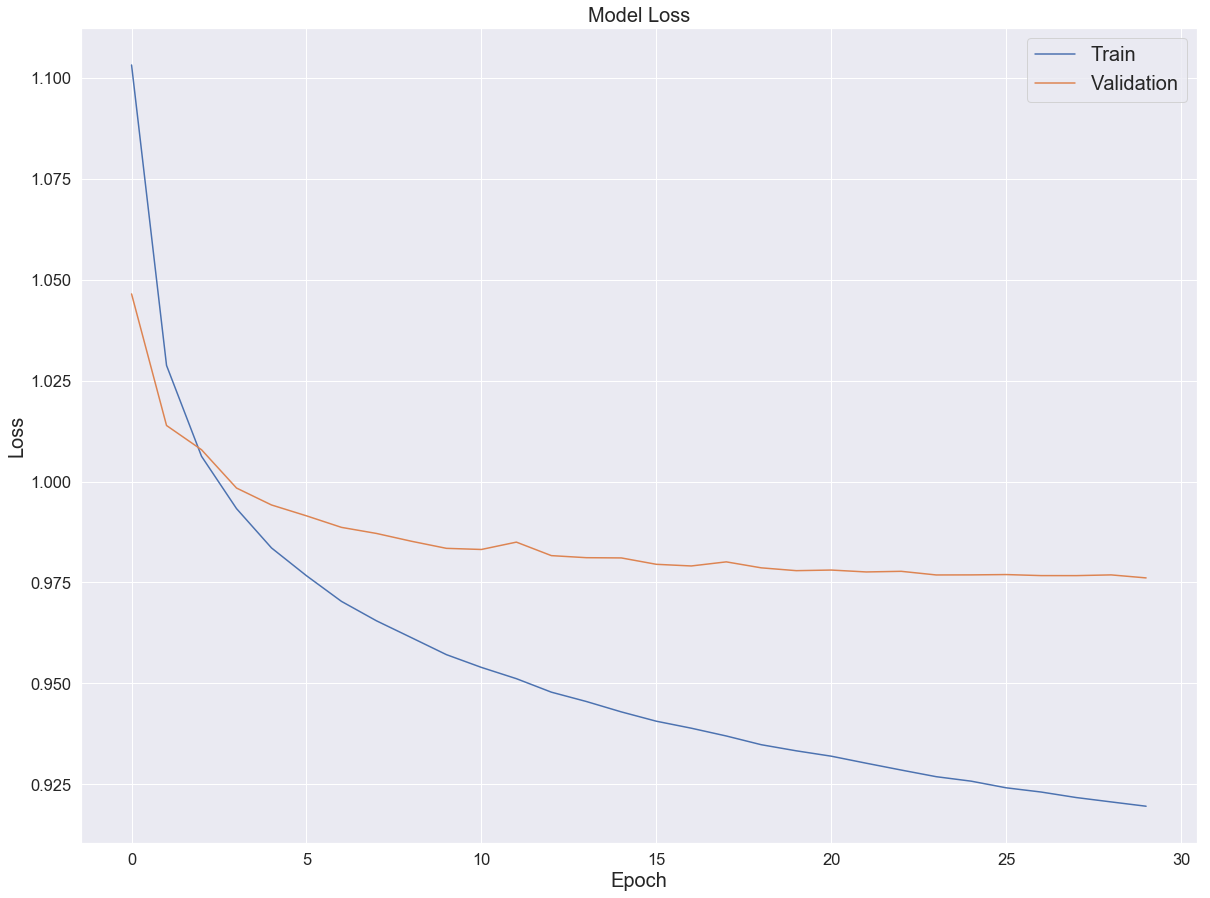

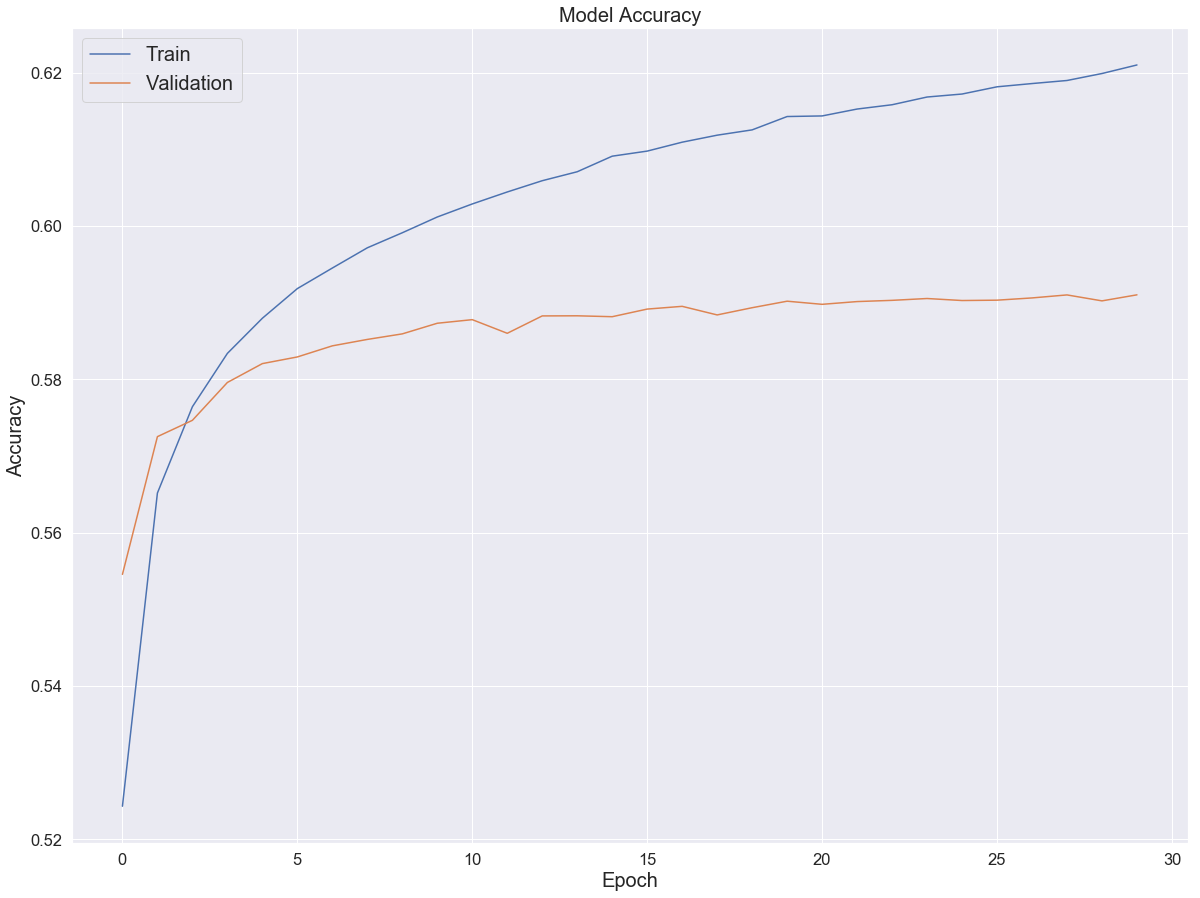

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.5)

plt.figure(figsize = (20,15))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

plt.figure(figsize = (20,15))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.xlabel('Epoch', fontsize = 20)
plt.legend(['Train', 'Validation'], fontsize = 20)
plt.show()

Here we will save the final model just in case although the best (in terms of validation accuracy) model was also saved automatically when training into the weights.best.hdf5 file.

In [33]:
model.save('DeepLearningMicrobiome.h5')

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we **evaluate the model on the test set and plot the results as a confusion matrix**.

In [27]:
from tensorflow import keras
model = keras.models.load_model('weights.best.hdf5')

Confusion matrix:
 [[44811 15124 17493  9433]
 [ 5895 59965 16194  5691]
 [10400 15512 48189 13688]
 [ 7000  7802 17463 55340]]


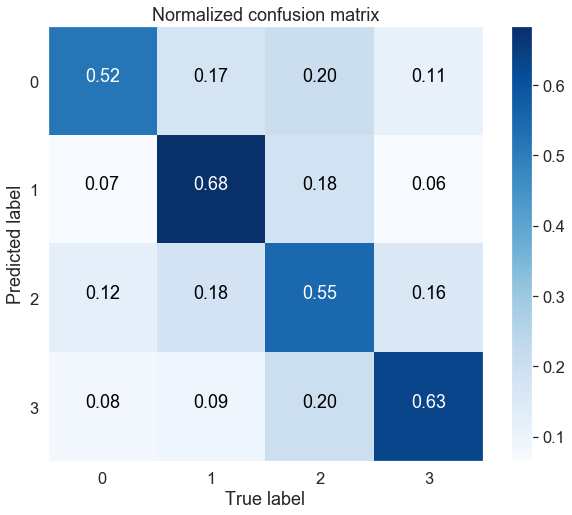

In [30]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.5)

from sklearn.metrics import confusion_matrix
import itertools

plt.figure(figsize = (10,8))

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis = 1), np.argmax(predicted_labels, axis = 1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1, 2, 3]); plt.yticks([0, 1, 2, 3])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center',
             color = 'white' if cm[i, j] > 0.5 else 'black')
plt.show()

The raw confusion matrix is printed out as a numpy array above. The graphical representation of the confusion matrix is the blueish heatmap that displays normalized accuracies per class. This is handy as one can immediately see that Oral and Skin microbial communities have lower accuracies of classfication compared to Gut and Vagina. This can be intiitively understood from the PCA plot in the beginning of this notebook, where Oral and Skin communities were quite mixed and less distinct from each other compared to Gut and Vagina clusters that lie separately from the rest. As an average of the blueish normalized confusion matrix above, one can use again the test data set (not used during training) and get an **average evaluation accuracy** which is almost **60%**.

In [29]:
scores = model.evaluate(test_features, test_labels, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 59.52%


The overall average evaluation accuracy of 60% might seem low at firt glance because our minds are set on a binary classification problem where a random classifier could give a basal accuracy of 50%. Therefore our result of 60% might seem just a little bit better than a random classifier. However, please recall that we are dealing here with 4 classes, and therefore a random classifier should give us an average accuracy of 25% (can be confirmed by simulations) with a standard deviation around 5-10% depending on the sample size. Therefore, the **accuracy of 60% is significantly higher than the basal 25% that one would expect from a random classifier**.

Now, when we have trained a classifier to assign a microbial DNA sequence to an Oral, Gut, Skin or Vagina class, let us try to chek whether it works well and assign an individual sequence to one of the 4 classes / tissues. Here we pick a random sequence (with index 100) from the test data set.

In [71]:
from tensorflow import keras
model = keras.models.load_model('weights.best_acc60_12genera.hdf5')

In [72]:
test_features[100,:,:]

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

We check the true class of the sequence which appears to be Oral, i.e. the 0 class:

In [73]:
test_labels[100,:]

array([1., 0., 0., 0.])

Now we are making class prediction for the selected sequence:

In [74]:
model.predict(test_features[100,:,:][np.newaxis,:,:])

array([[0.41876495, 0.0327576 , 0.38433418, 0.16414326]], dtype=float32)

In [75]:
model.predict_classes(test_features[100,:,:][np.newaxis,:,:])

array([0])

Here we see that the sequence with index 100 can be correctly assigned to belong to Oral bacteria since it gets the highest probability 42% for the Oral class, although Skin was also highly ranked, it got probability 38%. In the future, when we make predictions for a sample by averaging predictions for each sequence, we should probably only use sequences with most confident predictions, such as one class should have a probability >80%.

### Making Predictions of Microbial Composition <a class="anchor" id="Making-Predictions-of-Microbial-Composition"></a>

Here we are going to take a random FASTQ-file (from HMP or [DIABIMMUNE](https://diabimmune.broadinstitute.org/diabimmune/three-country-cohort)), make predictions for each sequence in the FASTQ-file, and present fractions of microbes (microbial composition) for the sample. Let us start with a Stool sample from the HMP project. We will read the sequences from the FASTQ-file:

In [1]:
from Bio import SeqIO

test_seq_list = []
fastq_path = '/home/nikolay/Documents/Medium/DeepLearningMetagenomics/'

#fastq_file = 'HMP_Oral_SRS011243.denovo_duplicates_marked.trimmed.singleton.fastq'
#fastq_file = 'HMP_Oral_SRS055495.denovo_duplicates_marked.trimmed.singleton.fastq'
#fastq_file = 'HMP_Gut_SRS017247.denovo_duplicates_marked.trimmed.singleton.fastq'
fastq_file = 'HMP_Gut_SRS022713.denovo_duplicates_marked.trimmed.singleton.fastq'
#fastq_file = 'HMP_Skin_SRS017156.denovo_duplicates_marked.trimmed.singleton.fastq'
#fastq_file = 'HMP_Skin_SRS018369.denovo_duplicates_marked.trimmed.singleton.fastq'
#fastq_file = 'HMP_Vagina_SRS015071.denovo_duplicates_marked.trimmed.singleton.fastq'
#fastq_file = 'HMP_Vagina_SRS062752.denovo_duplicates_marked.trimmed.singleton.fastq'

#fastq_file = 'ERR3827177.fastq'
#fastq_file = 'ERR3827196.fastq'
#fastq_file = 'G69153_pe_1.fastq'
#fastq_file = '4491200149-1L1_S12_L001_R1_001.fastq'
#fastq_file = '4491200209-1L1_S66_L001_R1_001.fastq'
#fastq_file = 'SRR6900017_1.fastq'
##fastq_file = 'SRR6899944_1.fastq'
#fastq_file = 'SRR6899929_1.fastq'

#for record in SeqIO.parse(fastq_path + fastq_file, "fastq"):
#    if record.id in ids_no_human and len(str(record.seq)) >= 80:
#        test_seq_list.append(str(record.seq))

for record in SeqIO.parse(fastq_path + fastq_file, "fastq"):
    if len(str(record.seq)) >= 80:
        test_seq_list.append(str(record.seq))

In [2]:
len(test_seq_list)

1134814

Since the sample is quite big, we will subsample random 100 000 sequences for classification. This is done to speed up the prediction.

In [3]:
import random
test_seq_list = random.sample(test_seq_list, 100000)
len(test_seq_list)

100000

Next, we will pre-process the data in the same way as the train data, i.e. we will trim all the sequences to 80 nt long DNA stretches, and we will exclude sequences that contain weird nucleitide, i.e. only A, C, T or G nucleotide are allowed to be present in the test data set.

In [4]:
nt = 80
test_seq_list = [j.rstrip()[0:nt] for j in test_seq_list]
test_seq_list = [k for k in test_seq_list if 
                 k.count('A') > 0 and k.count('C') > 0 and k.count('G') > 0 and k.count('T') > 0 
                 and len(list(k)) == nt and 'N' not in k and 'H' not in k and 'K' not in k 
                 and 'M' not in k and 'R' not in k and 'S' not in k and 'V' not in k 
                 and 'W' not in k and 'Y' not in k and 'B' not in k]

In [5]:
len(test_seq_list)

39435

In [6]:
test_seq_list[0]

'GGAGCCGTTAATAGTACGCTTATTGTAGATGAATTGGAGATTGTTGGTGAGTAATATTAAGTGTTAGTTATAAAAAGGGG'

Finally, we will need to one-hot encode the test data set in exactly the same way as we did for the train data set.

In [7]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

integer_encoder = LabelEncoder()  
one_hot_encoder = OneHotEncoder()   
input_test_features = []

for sequence in test_seq_list:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_test_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold = 40)
input_test_features = np.stack(input_test_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n', test_seq_list[0][:10],'...', test_seq_list[0][-10:])
print('One hot encoding of Sequence #1:\n',input_test_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 GGAGCCGTTA ... TAAAAAGGGG
One hot encoding of Sequence #1:
 [[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 0. 0. 0.]]


Now we will make a prediction for a random sequence with index 10 that was previously one-hot encoded.

In [18]:
input_test_features[10,:,:]

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [19]:
from tensorflow import keras
model = keras.models.load_model('weights.best_acc60_12genera.hdf5')

In [20]:
import warnings
warnings.filterwarnings("ignore")

model.predict_classes(input_test_features[10,:,:][np.newaxis,:,:])

array([1])

We see that the classifier correctly predicted the sequence number 10 to belong to class 1 which is Gut, this makes sense since we are making predictions for a Stool sample from HMP. This was just one sequence. Now we are going to make predictions for all sequences from the HMP Stool sample and summarize the predictions by counting how many sequences were assigned to each class using the Counter function from *collections* module.

In [21]:
predicted_test_labels = model.predict_classes(np.stack(input_test_features))
predicted_test_labels

array([2, 1, 2, ..., 2, 2, 1])

In [22]:
from collections import Counter
Counter(list(predicted_test_labels))

Counter({2: 12116, 1: 17422, 0: 5621, 3: 4276})

Here we see that the majority of sequences were correctly assigned to class 1 which is Gut. Let us convert these numbers into fractions / contributions of each class to the Stool HMP sample.

In [23]:
microbial_fractions = [Counter(list(predicted_test_labels))[0], 
                       Counter(list(predicted_test_labels))[1], 
                       Counter(list(predicted_test_labels))[2], 
                       Counter(list(predicted_test_labels))[3]]
microbial_fractions = [i / sum(microbial_fractions) for i in microbial_fractions]
microbial_fractions

[0.14253835425383543,
 0.4417902878153924,
 0.3072397616330671,
 0.10843159629770509]

Here we can see that the Gut class got the highest fraction of 44% followed by Skin that got 31% of sequences assigned to this calss. Therefore we conclude that the sample is **most likely from Gut / Stool**, and this agrees with what we know about the sample as SRS022713 sample was annotated as "Stool" in the HMP project.

If we now want to consider only most reliably classified sequences, we can filter the prediction results and keep only the sequences were one class exceeds a certain probability threshold such as 80%. But first we need to get probabilities for each of the 4 classes for all sequences from the HMP Stool sample.

In [24]:
predicted_test_probs = model.predict(np.stack(input_test_features))
predicted_test_probs

array([[0.13585883, 0.28136516, 0.3960894 , 0.18668664],
       [0.15251985, 0.50574493, 0.19219206, 0.14954309],
       [0.27487823, 0.20996936, 0.43254048, 0.08261193],
       ...,
       [0.34226823, 0.06785123, 0.5032913 , 0.08658928],
       [0.15907116, 0.1105382 , 0.52948785, 0.20090285],
       [0.10952581, 0.47515345, 0.3810129 , 0.03430786]], dtype=float32)

In [25]:
cutoff = 0.8
Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])

Counter({0: 546, 1: 1445, 2: 55, 3: 111})

In [26]:
microbial_fractions=[Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i))>cutoff]])[0], 
                     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i))>cutoff]])[1], 
                     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i))>cutoff]])[2], 
                     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i))>cutoff]])[3]]
microbial_fractions = [i / sum(microbial_fractions) for i in microbial_fractions]
microbial_fractions

[0.25312934631432543,
 0.6699119146963375,
 0.025498377375985166,
 0.05146036161335188]

Thus when we selected only sequences with most reliable predictions (where one class got more than 80% probability), we obtained 67% of microbial sequences assigned to the Gut class. Therefore, selecting most reliable sequences seems to make sense, however restricting the number of sequences we should still have a fair number so that it is still possible to do some statistics on them.

In [27]:
sum(Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]]).values())

2157

As we see, we still have enough sequences, i.e. over 2000, in order to realiably compute fractions of sequences assigned to each class.

Once we know how to make predictions of microbial composition for one sample, we will run predictions on 8 random samples from the HMP project. We will select 2 samples from each class, i.e. 2 Oral, 2 Gut, 2 Skin and 2 Vagina samples. Let us wrap the prediction procedure up as a loop over the samples:

In [1]:
from tensorflow import keras
model = keras.models.load_model('weights.best_acc60_12genera.hdf5')

In [2]:
import numpy as np
from Bio import SeqIO
from tensorflow import keras
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

tissue_list = ['Oral', 'Oral', 'Gut', 'Gut', 'Skin', 'Skin', 'Vagina', 'Vagina']
sample_list = ['SRS011243', 'SRS055495', 'SRS017247', 'SRS022713', 'SRS017156', 'SRS018369', 
               'SRS062752', 'SRS015071']

nt = 80
cutoff = 0.8
oral_list = []; gut_list = []; skin_list = []; vagina_list = []
fastq_path = '/home/nikolay/Documents/Medium/DeepLearningMetagenomics/'
for j in range(len(sample_list)):
    
    print('Working with sample ' + str(sample_list[j]) + ' from tissue ' + str(tissue_list[j]))
    
    test_seq_list = []
    fastq_file = 'HMP_' + tissue_list[j] + '_' + sample_list[j] + \
    '.denovo_duplicates_marked.trimmed.singleton.fastq'
    for record in SeqIO.parse(fastq_path + fastq_file, "fastq"):
        if len(str(record.seq)) >= 80:
            test_seq_list.append(str(record.seq))
    
    test_seq_list = [j.rstrip()[0:nt] for j in test_seq_list]
    test_seq_list = [k for k in test_seq_list if 
                     k.count('A') > 0 and k.count('C') > 0 and k.count('G') > 0 and k.count('T') > 0 
                     and len(list(k)) == nt and 'N' not in k and 'H' not in k and 'K' not in k 
                     and 'M' not in k and 'R' not in k and 'S' not in k and 'V' not in k 
                     and 'W' not in k and 'Y' not in k and 'B' not in k]
    
    integer_encoder = LabelEncoder()  
    one_hot_encoder = OneHotEncoder()   
    input_test_features = []
    for sequence in test_seq_list:
      integer_encoded = integer_encoder.fit_transform(list(sequence))
      integer_encoded = np.array(integer_encoded).reshape(-1, 1)
      one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
      input_test_features.append(one_hot_encoded.toarray())

    np.set_printoptions(threshold = 40)
    input_test_features = np.stack(input_test_features)

    #predicted_test_labels = model.predict_classes(np.stack(input_test_features))
    #microbial_fractions = [Counter(list(predicted_test_labels))[0], 
    #                       Counter(list(predicted_test_labels))[1], 
    #                       Counter(list(predicted_test_labels))[2], 
    #                       Counter(list(predicted_test_labels))[3]]
    
    predicted_test_probs = model.predict(np.stack(input_test_features))
    microbial_fractions=\
    [Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[0], 
     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[1], 
     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[2], 
     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[3]]

    microbial_fractions = [i / sum(microbial_fractions) for i in microbial_fractions]
    print(microbial_fractions)
    
    oral_list.append(microbial_fractions[0])
    gut_list.append(microbial_fractions[1])
    skin_list.append(microbial_fractions[2])
    vagina_list.append(microbial_fractions[3])

Working with sample SRS011243 from tissue Oral
[0.6865079365079365, 0.13558201058201058, 0.06514550264550265, 0.11276455026455026]
Working with sample SRS055495 from tissue Oral
[0.5350854013020395, 0.2299228865880318, 0.14764455761885314, 0.08734715449107551]
Working with sample SRS017247 from tissue Gut
[0.24464192368008364, 0.6309461578672243, 0.04286461055933089, 0.08154730789336122]
Working with sample SRS022713 from tissue Gut
[0.2560934182590234, 0.6720169851380042, 0.024033970276008492, 0.047855626326963906]
Working with sample SRS017156 from tissue Skin
[0.023255813953488372, 0.07905022474105922, 0.7347078366230213, 0.16298612468243112]
Working with sample SRS018369 from tissue Skin
[0.014901823281907433, 0.08003155680224404, 0.8174964936886395, 0.08757012622720897]
Working with sample SRS062752 from tissue Vagina
[0.11609989373007439, 0.29543039319872477, 0.052072263549415514, 0.5363974495217854]
Working with sample SRS015071 from tissue Vagina
[0.12919633774160733, 0.3336724

Let us summarize the fractions of each class for the 8 random HMP samples as a table and plot them as a stacked barplot.

In [3]:
import pandas as pd
df = pd.DataFrame({'Sample': [i + '_' + j for i, j in zip(tissue_list, sample_list)], 
                   'Oral': oral_list, 'Gut': gut_list, 'Skin': skin_list, 'Vagina': vagina_list})
df

Sample      Oral       Gut      Skin    Vagina
0    Oral_SRS011243  0.686508  0.135582  0.065146  0.112765
1    Oral_SRS055495  0.535085  0.229923  0.147645  0.087347
2     Gut_SRS017247  0.244642  0.630946  0.042865  0.081547
3     Gut_SRS022713  0.256093  0.672017  0.024034  0.047856
4    Skin_SRS017156  0.023256  0.079050  0.734708  0.162986
5    Skin_SRS018369  0.014902  0.080032  0.817496  0.087570
6  Vagina_SRS062752  0.116100  0.295430  0.052072  0.536397
7  Vagina_SRS015071  0.129196  0.333672  0.028993  0.508138

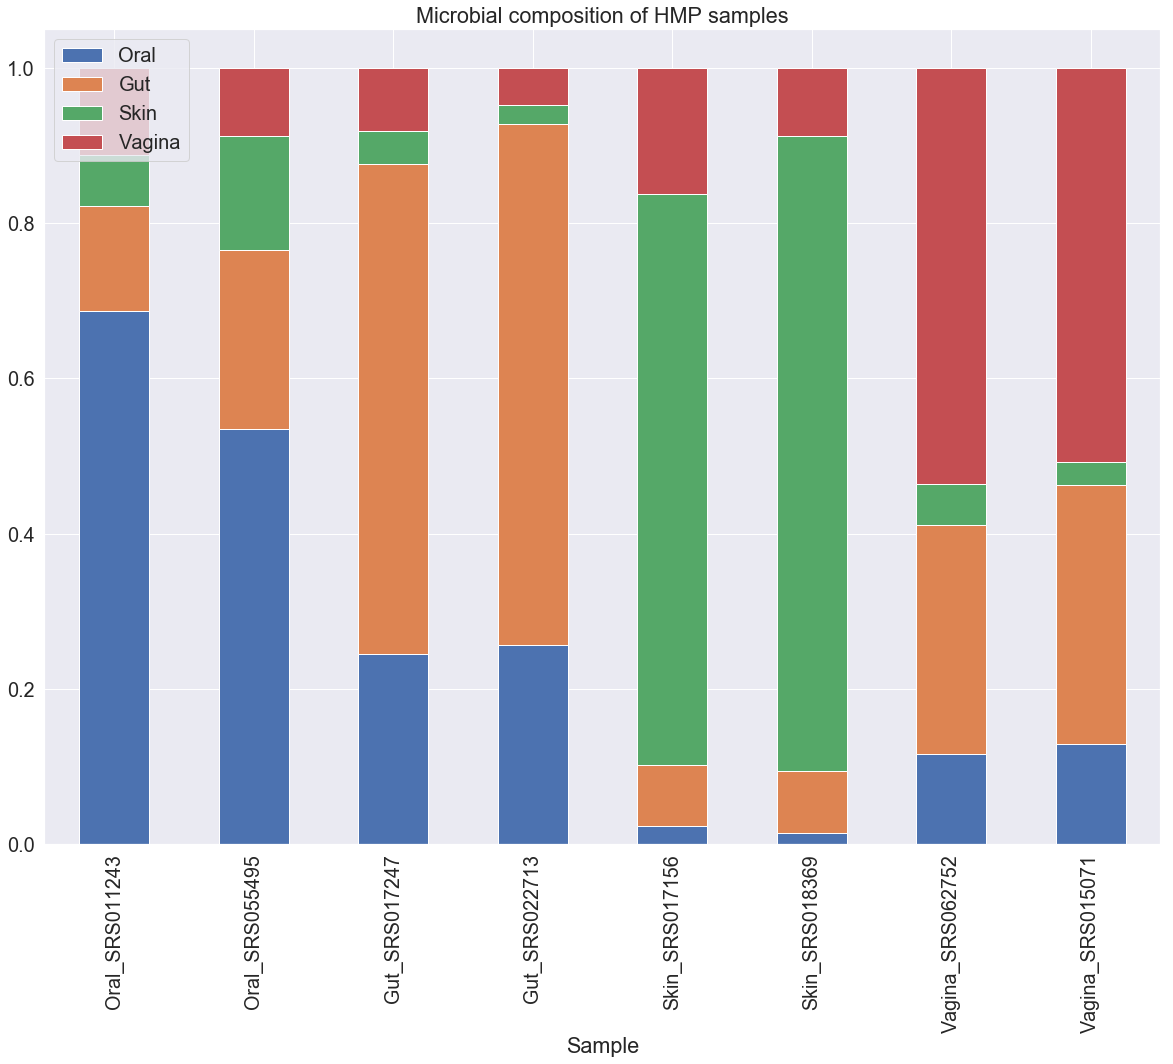

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.8)

df.plot(x = 'Sample', kind = 'bar', stacked = True, title = 'Microbial composition of HMP samples', 
        figsize = (20,15))
plt.legend(loc = 'upper left', prop = {'size': 20})
plt.show()

We can see that we get fairly good predictions for each random HMP sample, i.e. first two looks rather like Oral samples since Oral microbes (the blue bar) comprise the most of the microbial community, while the second two look like Gut samples etc.

Above, we trained a CNN classifier using **reference genomes** of microbes abundant in different tissues of HMP project. We proceeded with evaluating the model on a few random **HMP samples**. Here might be a problem. On the one hand, we did not use **raw sequences from the HMP samples** when training the CNN classifier, but instead we used the reference genomes of most abundant genera. On the other hand, there is still an **information leakage** because we still used the **same project** (althoug different types of data) for both training and evaluating. Therefore the evaluation might till be biased and look too good to be true. To make a better evaluation, we will select **8 random Oral, Gut, Skin and Vagina samples from random metagenomics projects that are not related to the HMP**.

Below, we will make predictions for a few samples other than HMP samples, i.e. the **DIABIMMUNE**, [files](https://diabimmune.broadinstitute.org/diabimmune/three-country-cohort/resources/metagenomic-sequence-data), the **WGS Oral Microbiome**, here are the [files](https://www.ebi.ac.uk/ena/browser/view/PRJEB36291?show=reads) and the [publication](https://bmcmicrobiol.biomedcentral.com/articles/10.1186/s12866-020-01801-y), projects. Skin samples were downloaded from the **MGnify resource** provided by the EBI from the project **"Patterns in the skin microbiota differ in children and teenagers between rural and urban environments"**, the files are [here](https://www.ebi.ac.uk/ena/browser/view/PRJEB14627?show=reads). Vaginal swabs were sequenced in the project **MOMS-PI**, the data are available from [here](https://www.ebi.ac.uk/ena/browser/view/PRJNA326441?show=reads).

We will apply the same loop over the samples as we used above for the HMP samples with only one difference. We need to always control that after applying a probability threshold (here 90%) we still get enough sequences to compute the fractions of microbial classes. If we do not have 500 sequences (this is true for some of the random non-HMP samples due to their low sequencing depth), the threshold will be lowered from 0.9 down to 0.6.

In [1]:
from tensorflow import keras
model = keras.models.load_model('weights.best_acc60_12genera.hdf5')

In [2]:
import random
import numpy as np
from Bio import SeqIO
from tensorflow import keras
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

random.seed(123)

import warnings
warnings.filterwarnings("ignore")

tissue_list = ['Oral', 'Oral', 'Gut', 'Gut', 'Skin', 'Skin', 'Vagina', 'Vagina']
sample_list = ['ERR3827177.fastq', 'ERR3827196.fastq', 'G69146_pe_1.fastq', 'G69153_pe_1.fastq', 
               '4491200149-1L1_S12_L001_R1_001.fastq', '4491200209-1L1_S66_L001_R1_001.fastq', 
               'SRR6900017_1.fastq', 'SRR6899929_1.fastq']

nt = 80
cutoff = 0.9
oral_list = []; gut_list = []; skin_list = []; vagina_list = []
fastq_path = '/home/nikolay/Documents/Medium/DeepLearningMetagenomics/'
for j in range(len(sample_list)):
    
    print('Working with sample ' + str(sample_list[j]) + ' from tissue ' + str(tissue_list[j]))
    
    test_seq_list = []
    fastq_file = sample_list[j]
    for record in SeqIO.parse(fastq_path + fastq_file, "fastq"):
        if len(str(record.seq)) >= 80:
            test_seq_list.append(str(record.seq))
    
    test_seq_list = random.sample(test_seq_list, 100000)
    test_seq_list = [j.rstrip()[0:nt] for j in test_seq_list]
    test_seq_list = [k for k in test_seq_list if 
                     k.count('A') > 0 and k.count('C') > 0 and k.count('G') > 0 and k.count('T') > 0 
                     and len(list(k)) == nt and 'N' not in k and 'H' not in k and 'K' not in k 
                     and 'M' not in k and 'R' not in k and 'S' not in k and 'V' not in k 
                     and 'W' not in k and 'Y' not in k and 'B' not in k]
    
    integer_encoder = LabelEncoder()  
    one_hot_encoder = OneHotEncoder()   
    input_test_features = []
    for sequence in test_seq_list:
      integer_encoded = integer_encoder.fit_transform(list(sequence))
      integer_encoded = np.array(integer_encoded).reshape(-1, 1)
      one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
      input_test_features.append(one_hot_encoded.toarray())

    np.set_printoptions(threshold = 40)
    input_test_features = np.stack(input_test_features)

    #predicted_test_labels = model.predict_classes(np.stack(input_test_features))
    #microbial_fractions = [Counter(list(predicted_test_labels))[0], 
    #                       Counter(list(predicted_test_labels))[1], 
    #                       Counter(list(predicted_test_labels))[2], 
    #                       Counter(list(predicted_test_labels))[3]]
    
    predicted_test_probs = model.predict(np.stack(input_test_features))
    if sum(Counter([np.argmax(j) for j in [i for i in predicted_test_probs \
                                           if max(list(i)) > cutoff]]).values()) < 500:
        cutoff = 0.6
    microbial_fractions=\
    [Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[0], 
     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[1], 
     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[2], 
     Counter([np.argmax(j) for j in [i for i in predicted_test_probs if max(list(i)) > cutoff]])[3]]

    microbial_fractions = [i / sum(microbial_fractions) for i in microbial_fractions]
    print('Probability cutoff: {}'.format(cutoff))
    print(microbial_fractions)
    
    oral_list.append(microbial_fractions[0])
    gut_list.append(microbial_fractions[1])
    skin_list.append(microbial_fractions[2])
    vagina_list.append(microbial_fractions[3])

Working with sample ERR3827177.fastq from tissue Oral
Probability cutoff: 0.9
[0.7179176755447942, 0.2245762711864407, 0.003026634382566586, 0.05447941888619855]
Working with sample ERR3827196.fastq from tissue Oral
Probability cutoff: 0.9
[0.6590314136125655, 0.1956806282722513, 0.002617801047120419, 0.14267015706806283]
Working with sample G69146_pe_1.fastq from tissue Gut
Probability cutoff: 0.9
[0.23803446075303128, 0.5207402680280792, 0.0, 0.2412252712188896]
Working with sample G69153_pe_1.fastq from tissue Gut
Probability cutoff: 0.9
[0.2803030303030303, 0.51010101010101, 0.0016835016835016834, 0.2079124579124579]
Working with sample 4491200149-1L1_S12_L001_R1_001.fastq from tissue Skin
Probability cutoff: 0.6
[0.000698661793948514, 0.000806148223786747, 0.9249744719729134, 0.07352071800935132]
Working with sample 4491200209-1L1_S66_L001_R1_001.fastq from tissue Skin
Probability cutoff: 0.6
[0.004672897196261682, 0.0053404539385847796, 0.9198931909212283, 0.07009345794392523]
Wo

In [3]:
import pandas as pd
df = pd.DataFrame({
    'Sample': 
    [i +'_'+j 
     for i,j in 
     zip(tissue_list,
         [k.replace('.fastq','').replace('_1','').replace('_001','').replace('_R1','').replace('_L001','') 
          for k in sample_list])], 'Oral': oral_list, 'Gut': gut_list, 'Skin': skin_list, 'Vagina': vagina_list})
df

Sample      Oral       Gut      Skin    Vagina
0          Oral_ERR3827177  0.717918  0.224576  0.003027  0.054479
1          Oral_ERR3827196  0.659031  0.195681  0.002618  0.142670
2            Gut_G69146_pe  0.238034  0.520740  0.000000  0.241225
3            Gut_G69153_pe  0.280303  0.510101  0.001684  0.207912
4  Skin_4491200149-1L1_S12  0.000699  0.000806  0.924974  0.073521
5  Skin_4491200209-1L1_S66  0.004673  0.005340  0.919893  0.070093
6        Vagina_SRR6900017  0.007692  0.053846  0.246154  0.692308
7        Vagina_SRR6899929  0.000569  0.001138  0.059727  0.938567

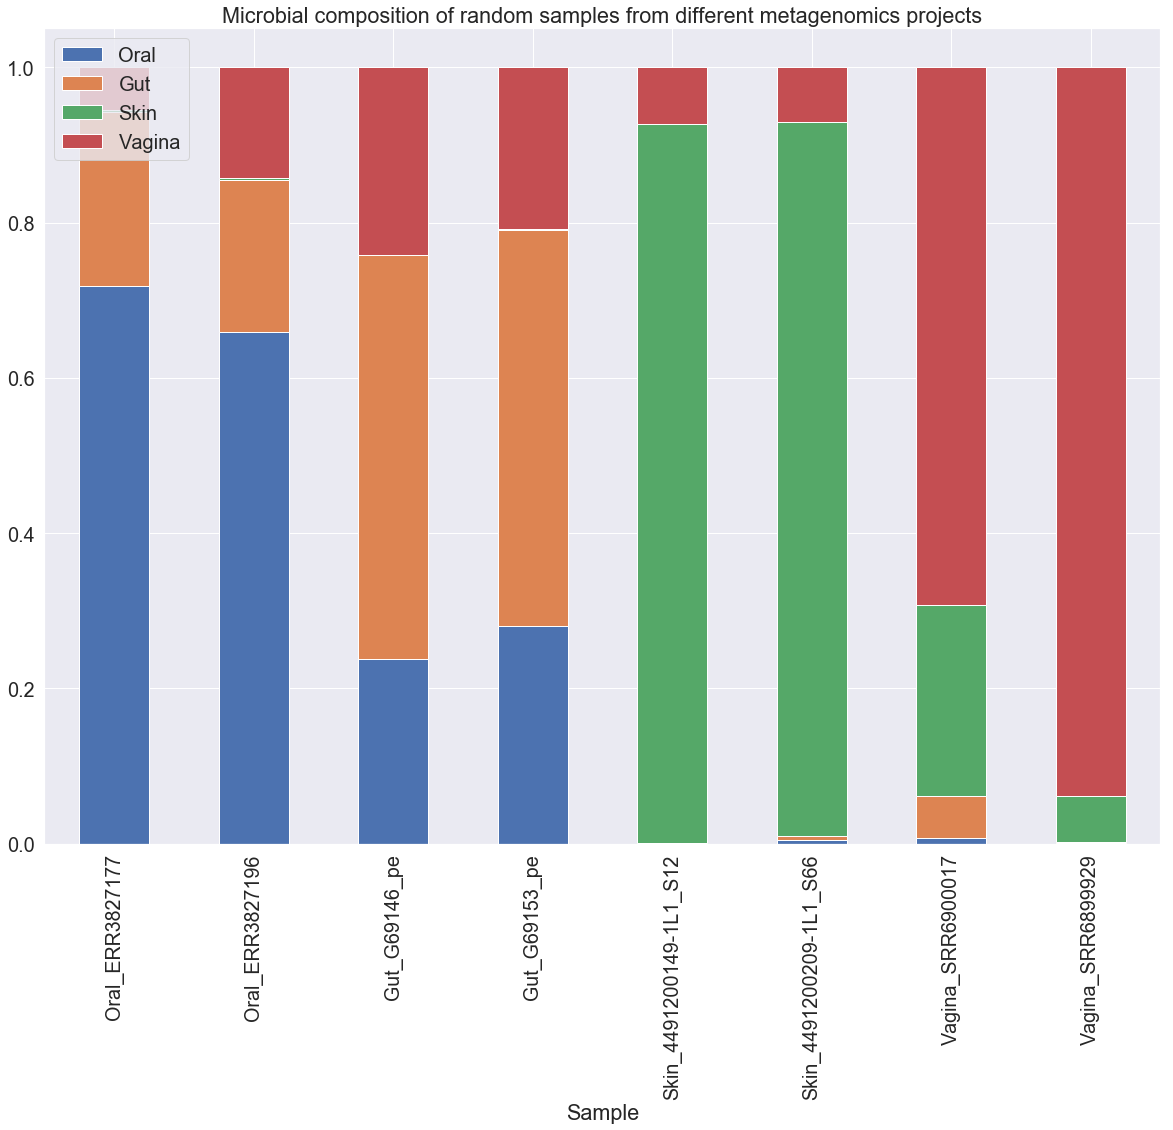

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale = 1.8)

df.plot(x = 'Sample', kind = 'bar', stacked = True, 
        title = 'Microbial composition of random samples from different metagenomics projects', figsize = (20,15))
plt.legend(loc = 'upper left', prop = {'size': 20})
plt.show()

Here we again see that the predictions of microbial compositions in the 8 non-HMP samples **fairly agree** with the true Oral, Gut, Skin and Vaginal microbial communities that the samples were taken from. Well done, our trained CNN classifier can provide meaningful estimates of microbial composition of any given sample.

### Temporary computations

Here we will save some handy codes that helped us in the analysis above. Later for the final version of the notebook, they should be removed.

In [18]:
[print(i) for i in microb.columns if 'Clostridium_perfringens' in i]

k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_perfringens
k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_perfringens|t__Clostridium_perfringens_unclassified


[None, None]

In [19]:
genus='k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium|s__Clostridium_perfringens'
microb.columns.get_loc(genus)

1055

In [23]:
ind = 1645
my_data = pd.DataFrame({'Tissue': list(['Oral']*phen['STArea'].value_counts()['Oral'] + 
                                           ['Skin']*phen['STArea'].value_counts()['Skin'] + 
                                           ['Vaginal']*phen['STArea'].value_counts()['Vaginal'] + 
                                           ['Gut']*phen['STArea'].value_counts()['Gut']),
                             'Abundance': list(microb.loc[phen['ID'][phen['STArea'] == 'Oral'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Skin'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Vaginal'],].iloc[:, ind]) + 
                             list(microb.loc[phen['ID'][phen['STArea'] == 'Gut'],].iloc[:, ind])})

In [24]:
my_data.groupby('Tissue', sort = False).mean().sort_values('Abundance', ascending = True)

Abundance
Tissue               
Skin     0.000000e+00
Gut      2.224231e-08
Oral     8.733916e-07
Vaginal  5.479060e-06

In [292]:
0.072794/0.000257

283.2451361867704